

# <p style="background-color:white;font-family:newtimeroman;color:darkred;font-size:150%;text-align:center;border-radius:20px 60px;">Sales Prediction for Chain of Stores - WALMART</p>

![](https://appinventiv.com/wp-content/uploads/sites/1/2019/09/Walmart%E2%80%99s-Journey-in-the-Blockchain-Arena-1.png)
<img src="./images/Walmart_Logo.png">

Predicting future sales for a company is one of the most important aspects of strategic planning. I wanted to analyze how internal and external factors of one of the biggest companies in the US can affect their Weekly Sales in the future. This module contains complete analysis of data , includes time series analysis , identifies the best performing stores , performs sales prediction with the help of multiple linear regression.

The data collected ranges from 2010 to 2012, where 45 Walmart stores across the country were included in this analysis. It is important to note that we also have external data available like CPI, Unemployment Rate and Fuel Prices in the region of each store which, hopefully, help us to make a more detailed analysis.

## Executive Summary

### Introduction
 
 In Retail Industry and chain of stores one of the biggest issue they face are supply chain management. The component of supply chain management (SCM) involved with determining how best to fulfill the requirements created from the Demand Plan. Its objective is to balance supply and demand in a manner that achieves the financial and service objectives of the enterprise.
  If we look into the case of a retail chain stores one of the basic case is to know the demand of products that are sold in the store. If the decision making authority know whats the demand of each products for a week or month, they would be able to plan the supply chain accordingly. If that is possible this would save a lot of money for them because they don't have to overstock or can plan their Logistics accordingly.
   
![](https://miro.medium.com/max/600/1*ixQ_TdPP3RmPQcPUzSVCrA.jpeg)

 
### Data

**There are 3 Datasets :**

 Stores:
- Store: The store number. Range from 1–45.
- Type: Three types of stores ‘A’, ‘B’ or ‘C’.
- Size: Sets the size of a Store would be calculated by the no. of products available in the particular store ranging from 34,000 to 210,000.

*primary key is Store*

[2.2] Sales:
-Date: The date of the week where this observation was taken.

-Weekly_Sales: The sales recorded during that Week.
-Store: The store which observation in recorded 1–45.
-Dept: One of 1–99 that shows the department.
-IsHoliday: Boolean value representing a holiday week or not.

*primary key is a combination of (Store,Dept,Date).*

[2.3] Features:

Temperature: Temperature of the region during that week.
-Fuel_Price: Fuel Price in that region during that week.
-MarkDown1:5 : Represents the Type of markdown and what quantity was available during that week.
-CPI: Consumer Price Index during that week.
-Unemployment: The unemployment rate during that week in the region of the store.

*primary key here is a combination of (Store,Date)*

![](https://i.imgur.com/XuDXqGU.png)


### Method

 I am breaking this problem into 2 stages
    1. Create a predictive model that predicts the weekly sales of 45 stores (In this stage I am not planning to predict the sales on department Level)
    2. Extend the project to Department Level (Future Work)
    
 I have done basic cleaning of the data I have and did some basic exploratory data analysis. From the insights I have got from the analysis I have further moved to creating models and fine tuning of models. I have used different type of Regression Models and Times Series Analysis to proceed and solve this stage.
 
 **List of Models -**
 
     1. Lasso Regressor
     2. Random Forest Regressor
     3. Gradient Boosting Regressor
     4. Support Vector Regressor
     5. Time Series Analysis
 
### Conclusion

 I have came up with different models that have helped me to predict the weekly sales of 45 stores with around 94% of accuracy for 3 months(90 Days). Out of the models I ran, I selected the Lasso Regressor as my predictive Model since It gave me the high accuracy of prediction with the lowest residual(error). 
 Even though I have selected one model as of now I am trying to predict sales for 45 stores. I am sure the impact of each feature might be different for different stores because of many reasons and thats why I checked how different is my prediction with each store.

<img src="./images/percentage_prediction_variation.png">

Here the bigger the bubble is the higher the variation in prediction. So we can see that there are 3 stores which have more than 5% variation in prediction. In the future study I can look into these store and try to see what goes wrong and using an ensembling method of getting prediction from different models try to improve the predictions

## Dataset Importing and Querying

I will load all 3 datasets and will merge the datasets into one big dataset that gives whole data. Since I am only predicting Store level sales after the loading I will group by such that I will eliminate Department level data and take the sum of department level sales to give the store level sales.

In [1]:
# Importing all necessary libraries to proceed with this project.

import warnings
import itertools
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import calendar
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import random
import sqlite3
from itertools import cycle, islice
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
# Import timedelta from datetime library
from datetime import timedelta


ss = StandardScaler()



In [2]:
pwd

'C:\\Users\\abajpai\\Desktop\\backup\\Time-Series_Sales_analysis'

In [3]:
sqlite_db = "data/train"
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

### 1. Load Dataset

In [4]:
walmart_path = './data/train.csv'
walmart = pd.read_csv(walmart_path)

walmart_feature_path = './data/features.csv'
walmart_feature = pd.read_csv(walmart_feature_path)

walmart_store_path = './data/stores.csv'
walmart_store = pd.read_csv(walmart_store_path)


In [5]:
walmart.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

**Group by Store**

Since we are am predicting the weekly sales for Store level, we will grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [6]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)


Merging all the datasets into one place so it will be easier for doing the test and analysis. 

While progressing through this project I was using SQL for writing the data to Local Database and using the join query I have merged data. 

I have changed those to python queries.

In [7]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store', left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)

data = pd.merge(result, walmart_feature, how='inner', on=['Store','Date'], left_on=None, right_on=None,
        left_index=False, right_index=False, sort=False,
        suffixes=('_x', '_y'), copy=True, indicator=False)


** The file with 421570 rows has come down to 6435 rows by doing a group by and merge ** 

I will make a SQL DB of this final dataset so that I can use it later without running all this steps or further use in some other area. 


### Data Cleaning/Munging
Now I will look through the data and do some basic cleaning and EDA 


In [8]:
print(data.shape)
data.head()

(6435, 15)


Store        Date  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0      1  2010-02-05    1643690.90    A  151315        42.31       2.572   
1      1  2010-02-12    1641957.44    A  151315        38.51       2.548   
2      1  2010-02-19    1611968.17    A  151315        39.93       2.514   
3      1  2010-02-26    1409727.59    A  151315        46.63       2.561   
4      1  2010-03-05    1554806.68    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday  
0         8.106      False  
1         8.106       True  
2         8.106      False  
3         8.106      False  
4         8.106      False

In [9]:
# Want to check the date column is in object format or datetime
data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [10]:
# yes my assumption was correct python have something to do with date format. 
# Now converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping

data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [11]:
# Lets look into the null values
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

** Oh thats huge. More Than 65% of value are missing in MarkDown values**
Let me look through the data describe so that I can impute sum values as of now for the missing 
MarkDown values and will decide later whether to use Markdown for modeling or should take some 
other approach for imputing or whether to discard MarkDowns totally from our case.


In [12]:
data.describe().T

count          mean            std         min         25%  \
Store         6435.0  2.300000e+01      12.988182       1.000      12.000   
Weekly_Sales  6435.0  1.046965e+06  564366.622054  209986.250  553350.105   
Size          6435.0  1.302876e+05   63117.022465   34875.000   70713.000   
Temperature   6435.0  6.066378e+01      18.444933      -2.060      47.460   
Fuel_Price    6435.0  3.358607e+00       0.459020       2.472       2.933   
MarkDown1     2280.0  6.855587e+03    8183.310015       0.270    1679.190   
MarkDown2     1637.0  3.218966e+03    9268.082387    -265.760      37.200   
MarkDown3     2046.0  1.349853e+03    9287.242800     -29.100       4.700   
MarkDown4     1965.0  3.303858e+03    6211.203947       0.220     483.270   
MarkDown5     2295.0  4.435262e+03    5868.933325     135.160    1702.565   
CPI           6435.0  1.715784e+02      39.356712     126.064     131.735   
Unemployment  6435.0  7.999151e+00       1.875885       3.879       6.891   
Day           6435.0  1.567832e+01       8.755780       1.000       8.000   
Year          6435.0  2.010965e+03       0.797019    2010.000    2010.000   

                        50%           75%           max  
Store             23.000000  3.400000e+01  4.500000e+01  
Weekly_Sales  960746.040000  1.420159e+06  3.818686e+06  
Size          126512.000000  2.023070e+05  2.196220e+05  
Temperature       62.670000  7.494000e+01  1.001400e+02  
Fuel_Price         3.445000  3.735000e+00  4.468000e+00  
MarkDown1       4972.590000  8.873583e+03  8.864676e+04  
MarkDown2        187.040000  1.785290e+03  1.045195e+05  
MarkDown3         22.700000  9.998750e+01  1.416306e+05  
MarkDown4       1419.420000  3.496080e+03  6.747485e+04  
MarkDown5       3186.520000  5.422080e+03  1.085193e+05  
CPI              182.616521  2.127433e+02  2.272328e+02  
Unemployment       7.874000  8.622000e+00  1.431300e+01  
Day               16.000000  2.300000e+01  3.100000e+01  
Year            2011.000000  2.012000e+03  2.012000e+03

In [13]:
data['Week'] = data.Date.dt.isocalendar().week 

In [14]:
data.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [15]:
df_weeks = data.groupby('Week').sum()

import plotly.express as px
fig = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, title = 'Sales over weeks')
fig.update_traces(line_color='deeppink', line_width=3)

In [16]:
import plotly.graph_objs as go
from plotly import tools

fig = go.Figure()

fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.update_layout(title = 'Sales vs Markdown1', xaxis_title = 'Weeks')

In [17]:
# imputing the values with (-500) since those are missing values and -500 could be a easy way to find the values 
# later and at the same time by putting "NA" the columns types dont have to be changed to Object.
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

# I am changing this later

In [18]:
# Will convert the bool to 1 and 0 for easier use later.
data.IsHoliday=data.IsHoliday.map(lambda x: 1 if x==True else 0)

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



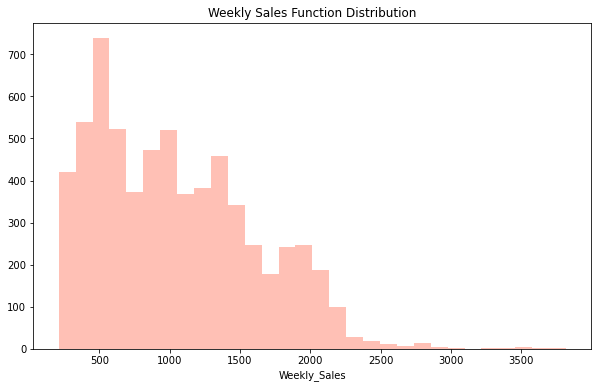

In [19]:
# From the Describe function we see that weekly sales for each store are very high. 
# we will scale down the value for ease of use and revert back when we look residuals or where necessary

plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()



In the Distribution Natural Log of Sales and the square root of Sales look better distributed . I might use Natural Log for predictions later


In [20]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

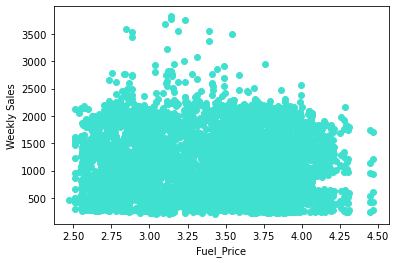

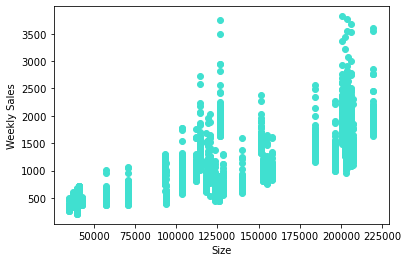

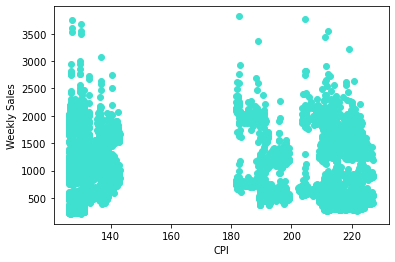

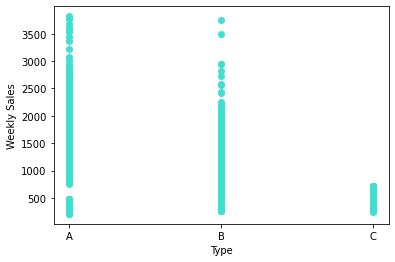

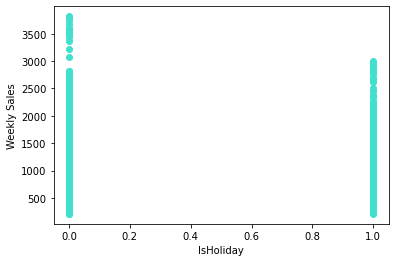

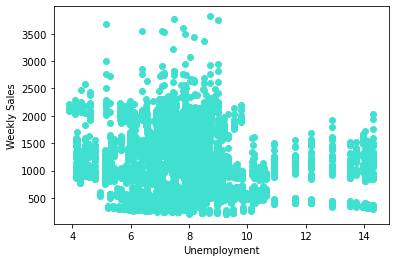

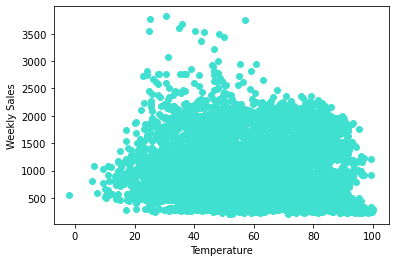

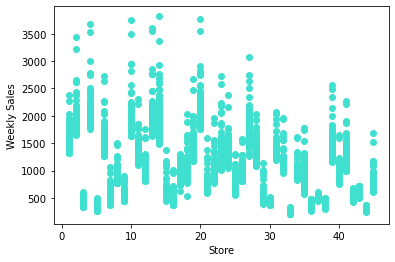

In [21]:
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')


In [22]:
data['Week'] = data.Date.dt.isocalendar().week 

In [23]:
data.head()

Store       Date  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0      1 2010-02-05    1643.69090    A  151315        42.31       2.572   
1      1 2010-02-12    1641.95744    A  151315        38.51       2.548   
2      1 2010-02-19    1611.96817    A  151315        39.93       2.514   
3      1 2010-02-26    1409.72759    A  151315        46.63       2.561   
4      1 2010-03-05    1554.80668    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0     -500.0     -500.0     -500.0     -500.0     -500.0  211.096358   
1     -500.0     -500.0     -500.0     -500.0     -500.0  211.242170   
2     -500.0     -500.0     -500.0     -500.0     -500.0  211.289143   
3     -500.0     -500.0     -500.0     -500.0     -500.0  211.319643   
4     -500.0     -500.0     -500.0     -500.0     -500.0  211.350143   

   Unemployment  IsHoliday  Day Month  Year  Week  
0         8.106          0    5   Feb  2010     5  
1         8.106          1   12   Feb  2010     6  
2         8.106          0   19   Feb  2010     7  
3         8.106          0   26   Feb  2010     8  
4         8.106          0    5   Mar  2010     9

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



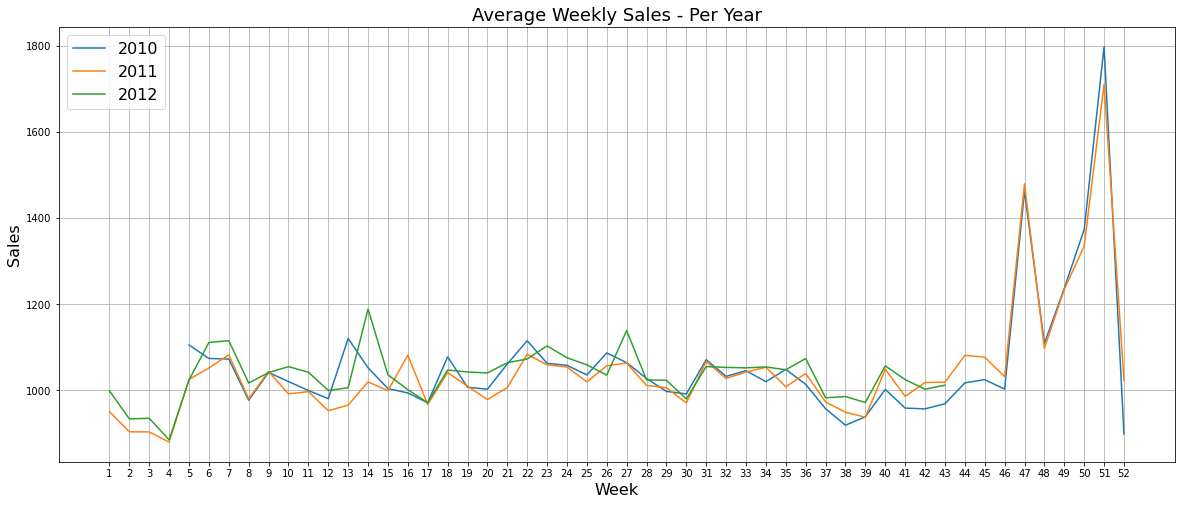

In [24]:
weekly_sales_2010 = data[data.Year==2010]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2011 = data[data.Year==2011]['Weekly_Sales'].groupby(data['Week']).mean()
weekly_sales_2012 = data[data.Year==2012]['Weekly_Sales'].groupby(data['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


### As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012

and, finally, Week 13 in 2013 for Test set

**So, we can change to 'True' these Weeks in each Year.**

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



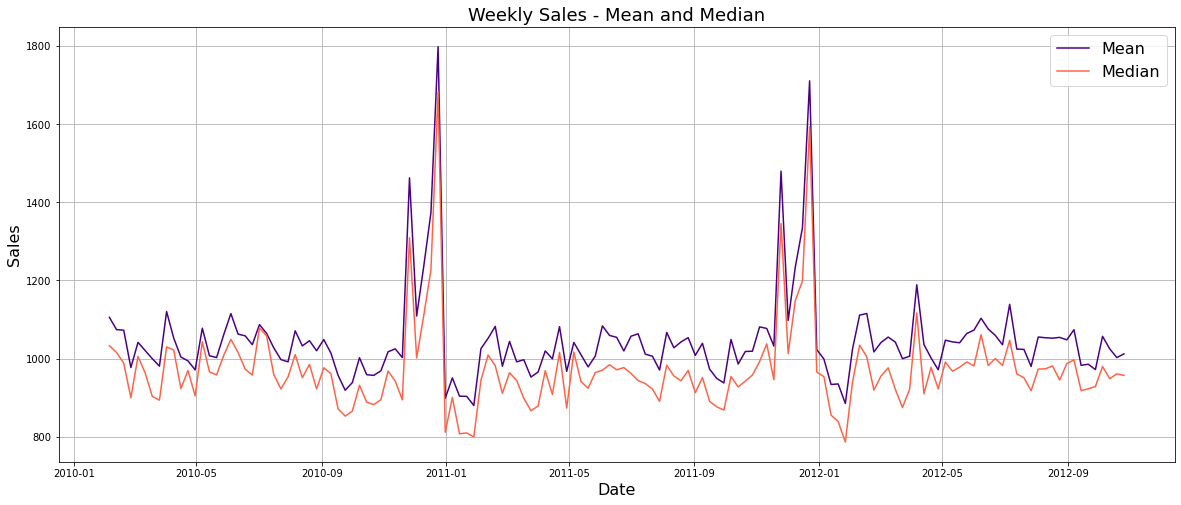

In [25]:
weekly_sales_mean = data['Weekly_Sales'].groupby(data['Date']).mean()
weekly_sales_median = data['Weekly_Sales'].groupby(data['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values, color = 'indigo')
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values, color = 'tomato')
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

C:\Users\abajpai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



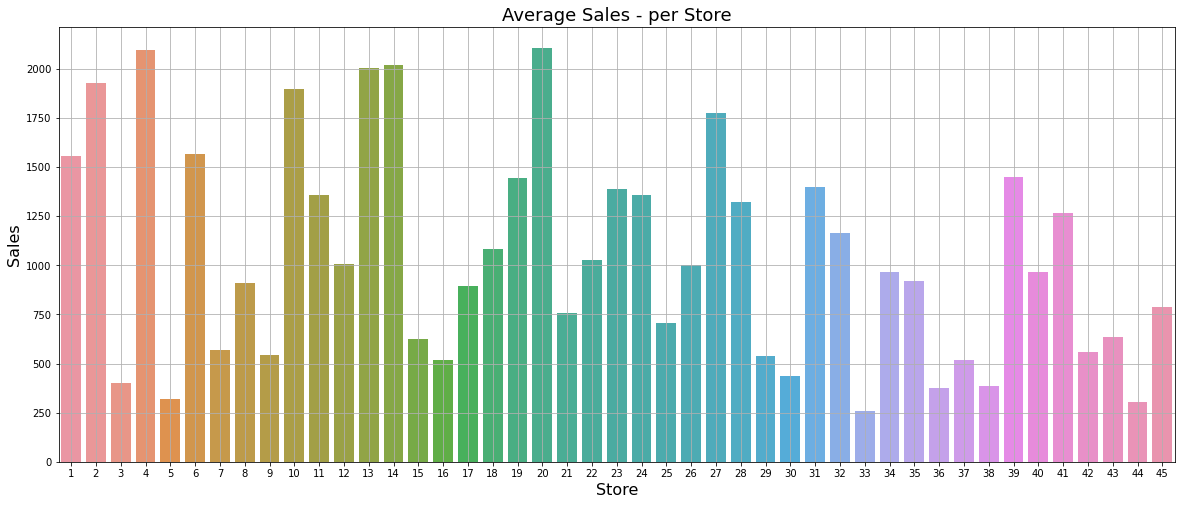

In [26]:
weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20,8))
plt.style.use('default')
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

C:\Users\abajpai\AppData\Local\Temp\5/ipykernel_14608/3958741546.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



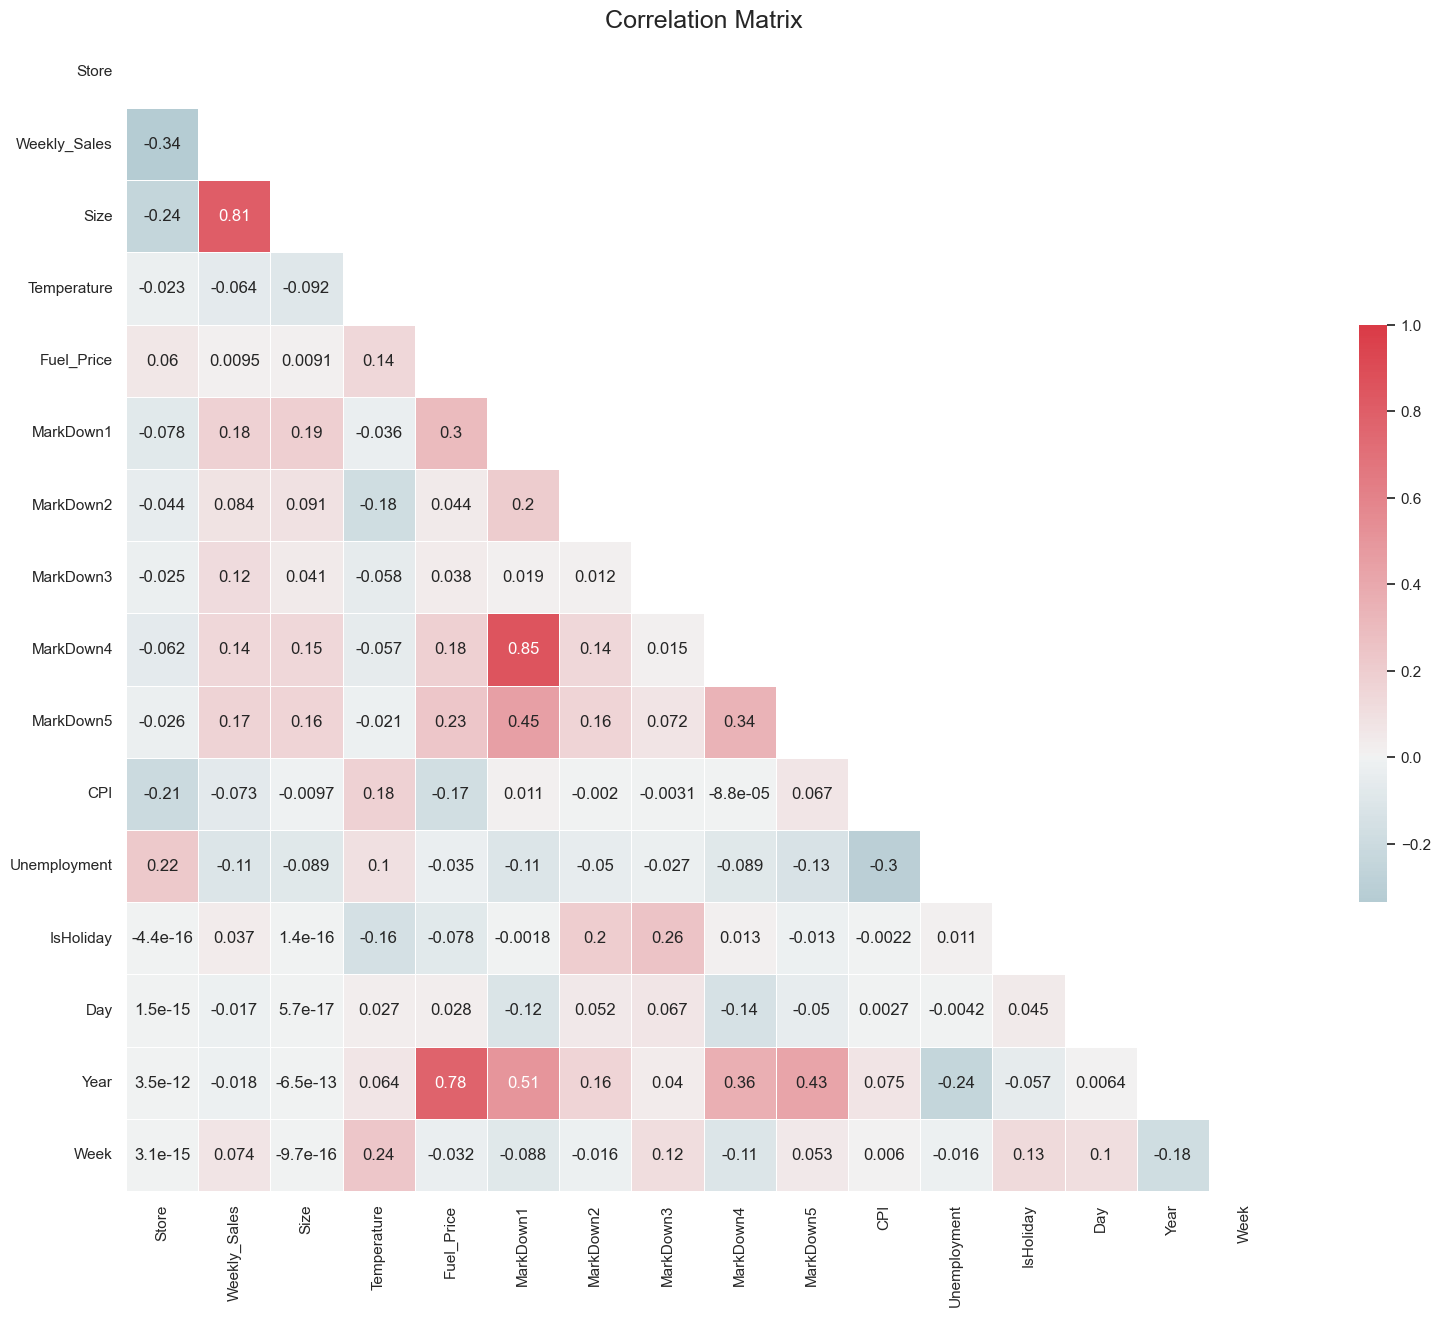

In [27]:
sns.set(style="white")

corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

# <p style="background-color:white;font-family:newtimeroman;color:darkred;font-size:150%;text-align:center;border-radius:20px 60px;">Detailed Time-Series Analysis</p>

## What is Time Series <a id ="1"></a>
Any data recorded with some fixed interval of time is called as time series data. This fixed interval can be hourly, daily, monthly or yearly. e.g. hourly temp reading, daily changing fuel prices, monthly electricity bill, annul company profit report etc. In time series data, time will always be independent variable and there can be one or many dependent variable. 

Sales forecasting time series with shampoo sales for every month will look like this, 

![Shampoo_Sales](https://raw.githubusercontent.com/satishgunjal/images/master/Shampoo_Sales.png)

In above example since there is only one variable dependent on time so its called as univariate time series. If there are multiple dependent variables, then its called as multivariate time series.

Objective of time series analysis is to understand how change in time affect the dependent variables and accordingly predict values for future time intervals.



## Stationary Data <a id ="9"></a>
For accurate analysis and forecasting trend and seasonality is removed from the time series and converted it into stationary series.
Time series data is said to be stationary when statistical properties like mean, standard deviation are constant and there is no seasonality. In other words statistical properties of the time series data should not be a function of time.

![Stationarity](https://raw.githubusercontent.com/satishgunjal/images/master/Stationarity.png)

## Test for Stationarity <a id ="10"></a>
Easy way is to look at the plot and look for any obvious trend or seasonality. While working on real world data we can also use more sophisticated methods like rolling statistic and Augmented Dickey Fuller test to check stationarity of the data. 

### Rolling Statistics <a id ="11"></a>
In rolling statistics technique we define a size of window to calculate the mean and standard deviation throughout the series. For stationary series mean and standard deviation shouldn't change with time.

### Augmented Dickey Fuller (ADF) Test <a id ="12"></a>
I won't go into the details of how this test works. I will concentrate more on how to interpret the result of this test to determine the stationarity of the series. ADF test will return 'p-value' and 'Test Statistics' output values.
* **p-value > 0.05**: non-stationary.
* **p-value <= 0.05**: stationary.
* **Test statistics**: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series











### We will consider one of the stores and perform a detailed time-series analysis on it

### Store 4

In [28]:
data1 = pd.read_csv(walmart_path)
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)



### Store 6

In [29]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

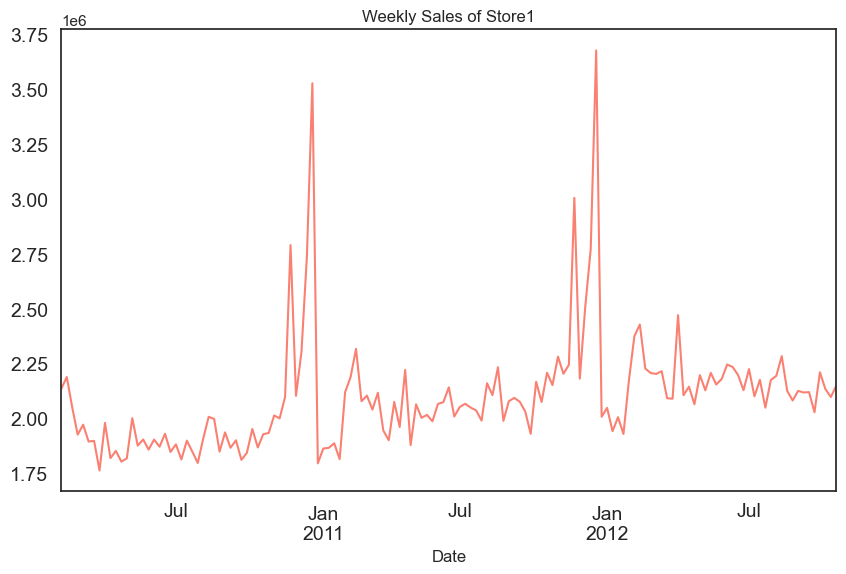

In [30]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store1', fontsize=14, color = 'salmon')
plt.show()

# <p style="background-color:white;font-family:newtimeroman;color:darkred;font-size:150%;text-align:center;border-radius:20px 60px;">Time Series Components</p>

## Time Series Characteristics <a id ="2"></a>
Mean, standard deviation and seasonality defines different characteristics of the time series. 

![Time_Series_Characteristics](https://raw.githubusercontent.com/satishgunjal/images/master/Time_Series_Characteristics.png)

Important characteristics of the time series are as below

### Trend <a id ="3"></a>
Trend represent the change in dependent variables with respect to time from start to end. In case of increasing trend dependent variable will increase with time and vice versa. It's not necessary to have definite trend in time series, we can have a single time series with increasing and decreasing trend. In short trend represent the varying mean of time series data.

![Trend](https://raw.githubusercontent.com/satishgunjal/images/master/Trend.png)

### Seasonality <a id ="4"></a>
If observations repeats after fixed time interval then they are referred as seasonal observations. These seasonal changes in data can occur because of natural events or man-made events. For example every year warm cloths sales increases just before winter season. So seasonality represent the data variations at fixed intervals.

![Seasonality](https://raw.githubusercontent.com/satishgunjal/images/master/Seasonality.png)

### Irregularities <a id ="5"></a>
This is also called as noise. Strange dips and jump in the data are called as irregularities. These fluctuations are caused by uncontrollable events like earthquakes, wars, flood, pandemic etc. For example because of COVID-19 pandemic there is huge demand for hand sanitizers and masks.

![Irregularities](https://raw.githubusercontent.com/satishgunjal/images/master/Irregularities.png)

### Cyclicity <a id ="6"></a>
Cyclicity occurs when observations in the series repeats in random pattern. Note that if there is any fixed pattern then it becomes seasonality, in case of cyclicity observations may repeat after a week, months or may be after a year. These kinds of patterns are much harder to predict.

![Cyclicity](https://raw.githubusercontent.com/satishgunjal/images/master/Cyclicity.png)

Time series data which has above characteristics is called as 'Non-Stationary Data'. For any analysis on time series data we must convert it to 'Stationary Data'

The general guideline is to estimate the trend and seasonality in the time series, and then make the time series stationary for data modeling. In data modeling step statistical techniques are used for time series analysis and forecasting. Once we have the predictions, in the final step forecasted values converted into the original scale by applying trend and seasonality constraints back.


# Time Series Analysis <a id ="7"></a>
As name suggest its analysis of the time series data to identify the patterns in it. I will briefly explain the different techniques and test for time series data analysis.

## Decomposition of Time Series <a id ="8"></a>
Time series decomposition helps to deconstruct the time series into several component like trend and seasonality for better visualization of its characteristics. Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data

![Decomposition_of_Time_Series](https://raw.githubusercontent.com/satishgunjal/images/master/Decomposition_of_Time_Series.png)

### Additive Decomposition

* An additive model suggests that the components are added together.
* An additive model is linear where changes over time are consistently made by the same amount.
* A linear seasonality has the same frequency (width of the cycles) and amplitude (height of the cycles).

The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). You need to specify whether the model is additive or multiplicative.

The seasonal_decompose() function returns a result object which contains arrays to access four pieces of data from the decomposition.

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


<Figure size 640x480 with 0 Axes>

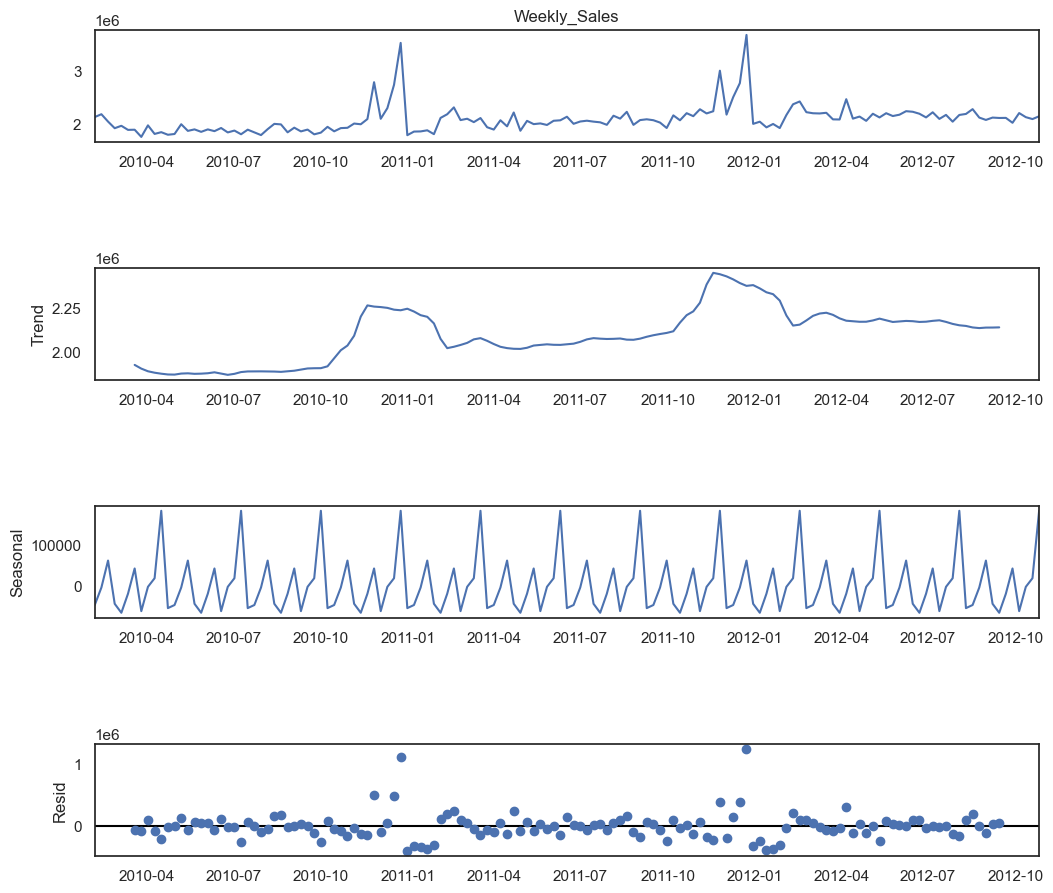

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

### Multiplicative model

### Multiplicative Decomposition

* An additive model suggests that the components are multipled together.
* An additive model is non-linear such as quadratic or exponential. 
* Changes increase or decrease over time.
* A non-linear seasonality has an increasing or decreasing frequency (width of the cycles) and / or amplitude (height of the cycles) over time.

<Figure size 640x480 with 0 Axes>

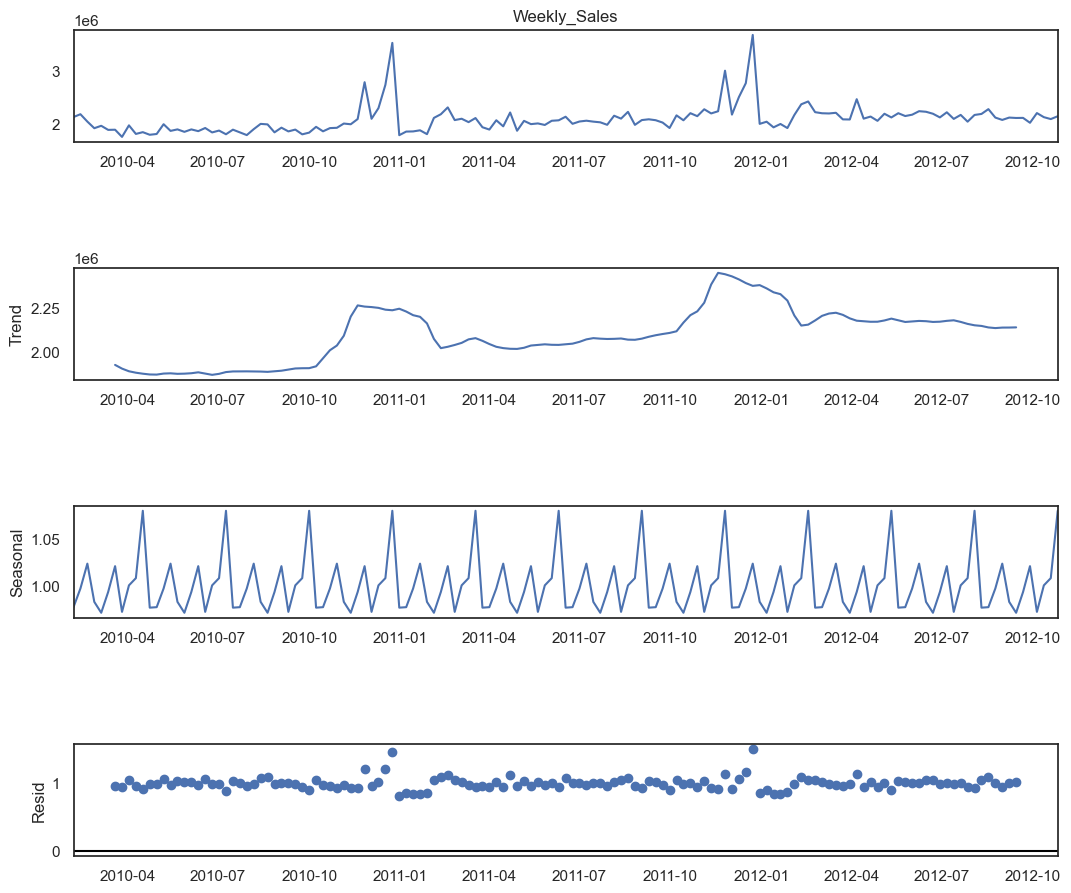

In [32]:
decomposition = seasonal_decompose(sales4.Weekly_Sales, model= 'multiplicative', period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [33]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

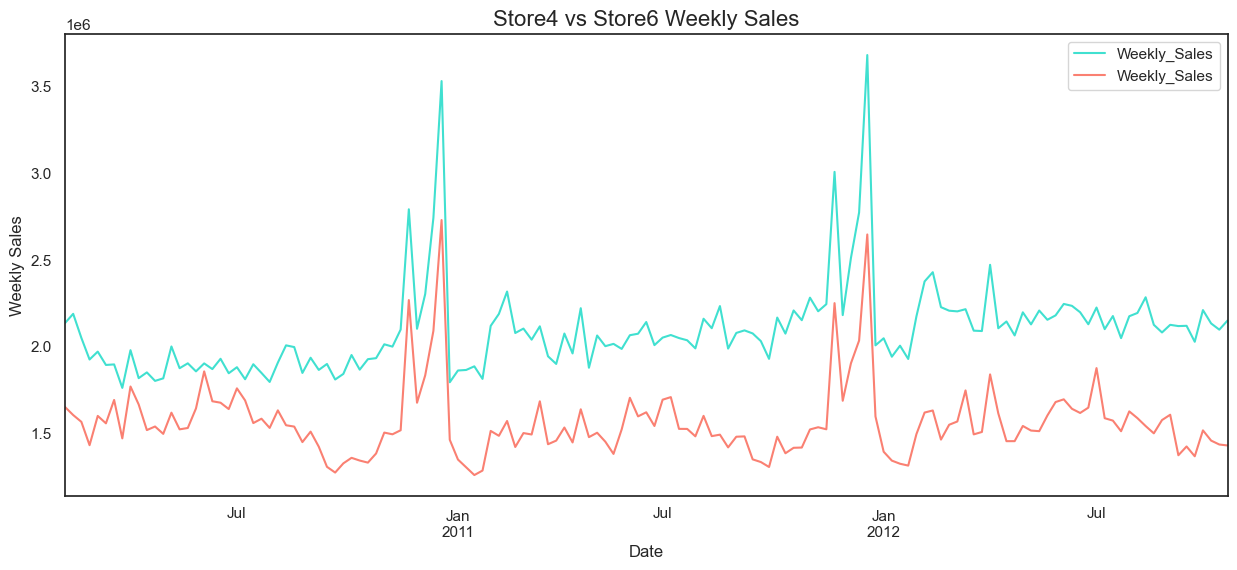

In [34]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

#### This shows an interesting trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude is different. 
    This clearly tells its a timeseries problem and it will be interesting to look more into it

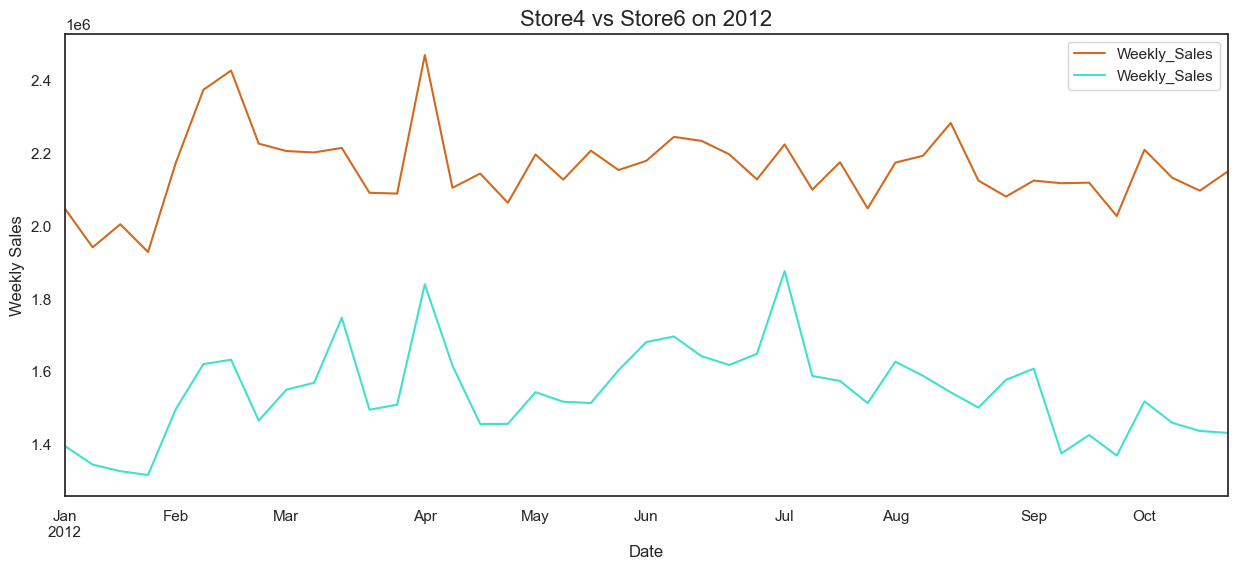

In [35]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

#### Not quite a trend. Here comes yet another component of timeseries - Irregular component

    which are other non random sources of variations of series and are mainly the impact of random events such as strikes, earthquakes, and sudden changes in the weather. By their nature, these effects are completely unpredictable.

In [36]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]


In [37]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y1,
                                             order=param,
                                             seasonal_order=param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}13 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [38]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7523      0.539     -3.250      0.001      -2.809      -0.696
ar.L2         -1.2917      0.580     -2.228      0.026      -2.428      -0.155
ar.L3         -0.5958      0.250     -2.381      0.017      -1.086      -0.105
ar.L4         -0.1894      0.091     -2.083      0.037      -0.368      -0.011
ma.L1         -1.3776      0.490     -2.812      0.005      -2.338      -0.417
ma.L2         -0.2216      1.053     -0.210      0.833      -2.286       1.843
ma.L3          0.6033      0.588      1.027      0.305      -0.549       1.755
ar.S.L52      -0.0672      0.048     -1.387      0.166      -0.162       0.028
sigma2      1.622e+10   6.24e-11    2.6e+20      0.000    1.62e+10    1.62e+10


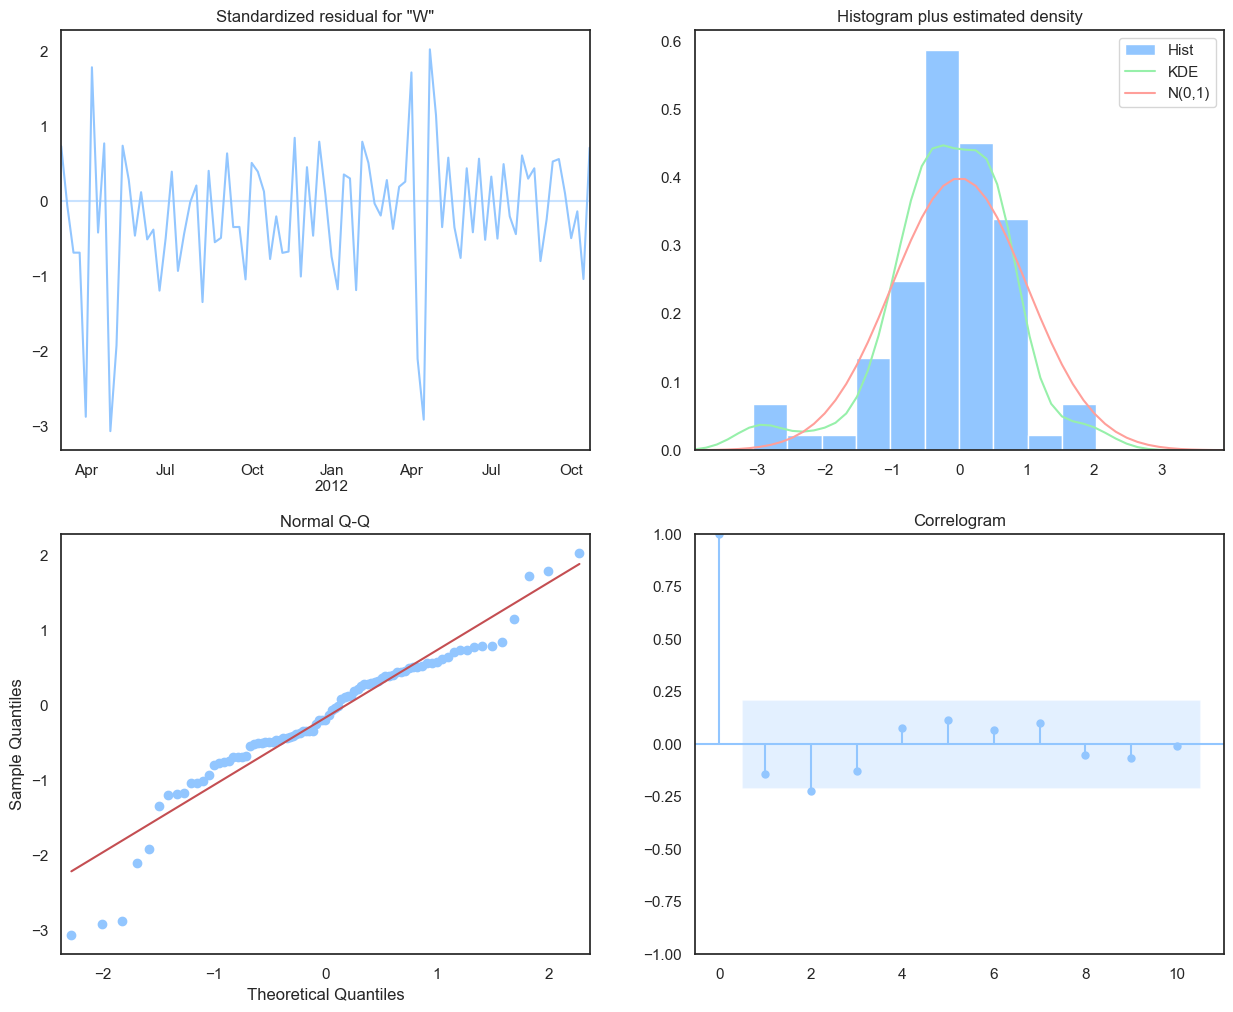

In [39]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [40]:
# Will predict for last 90 days. So setting the date according to that
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

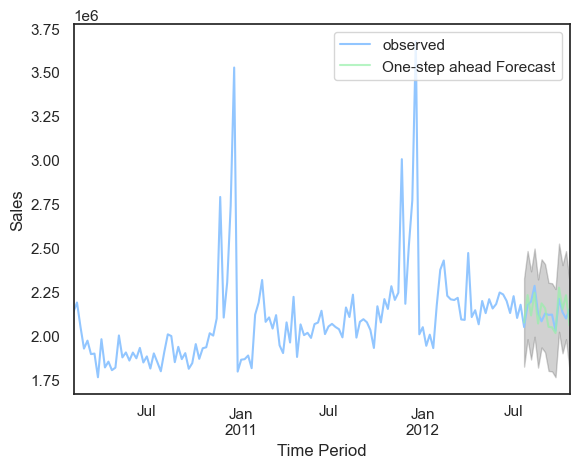

In [41]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [42]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4746677990.42


In [43]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

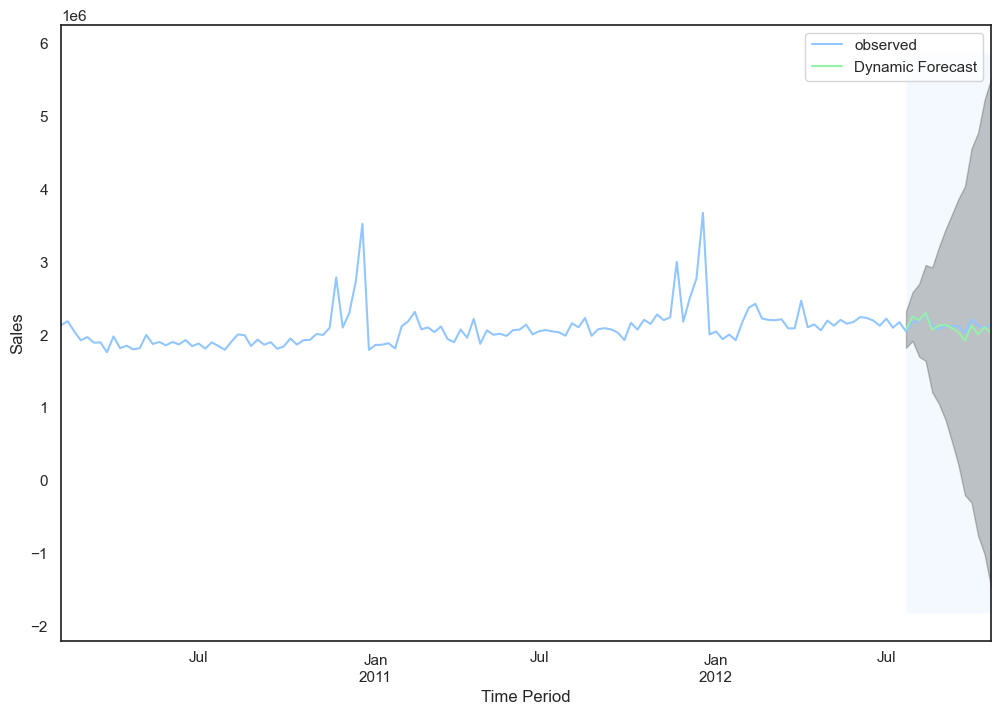

In [44]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [45]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 69564.13


In [46]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 794146.4453147729


In [47]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

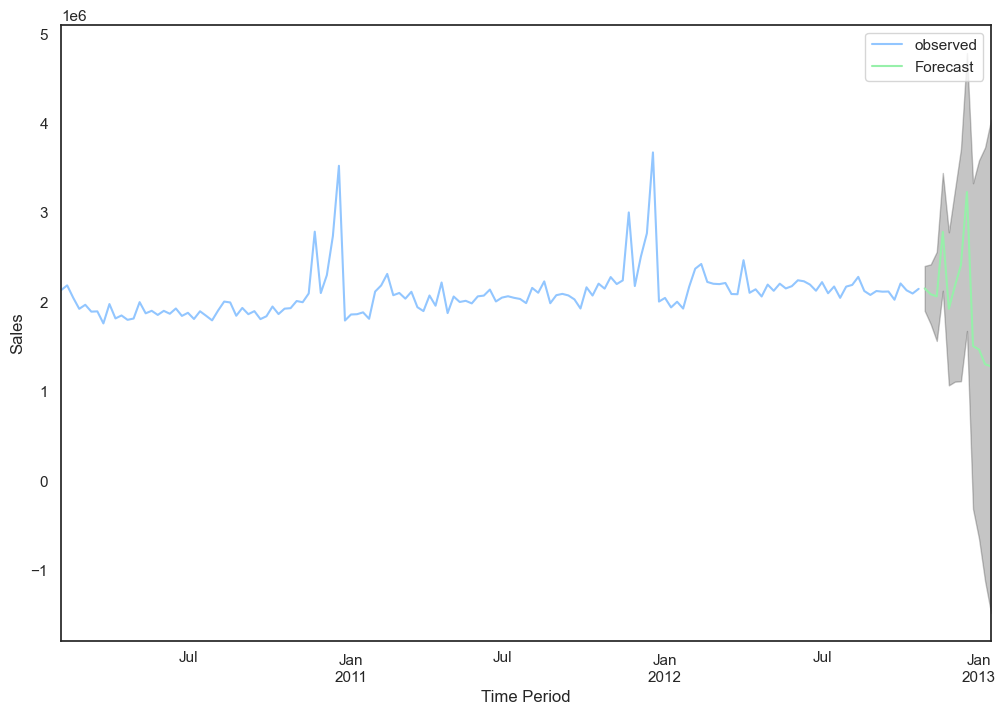

In [48]:
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

For future prediction the model is not that great because the error interval is way big. But if we just check the red line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better and error is also low.

## Back to usual anaylsis & Machine learning

In [49]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis 

In [50]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

## Statistical analysis and correlations

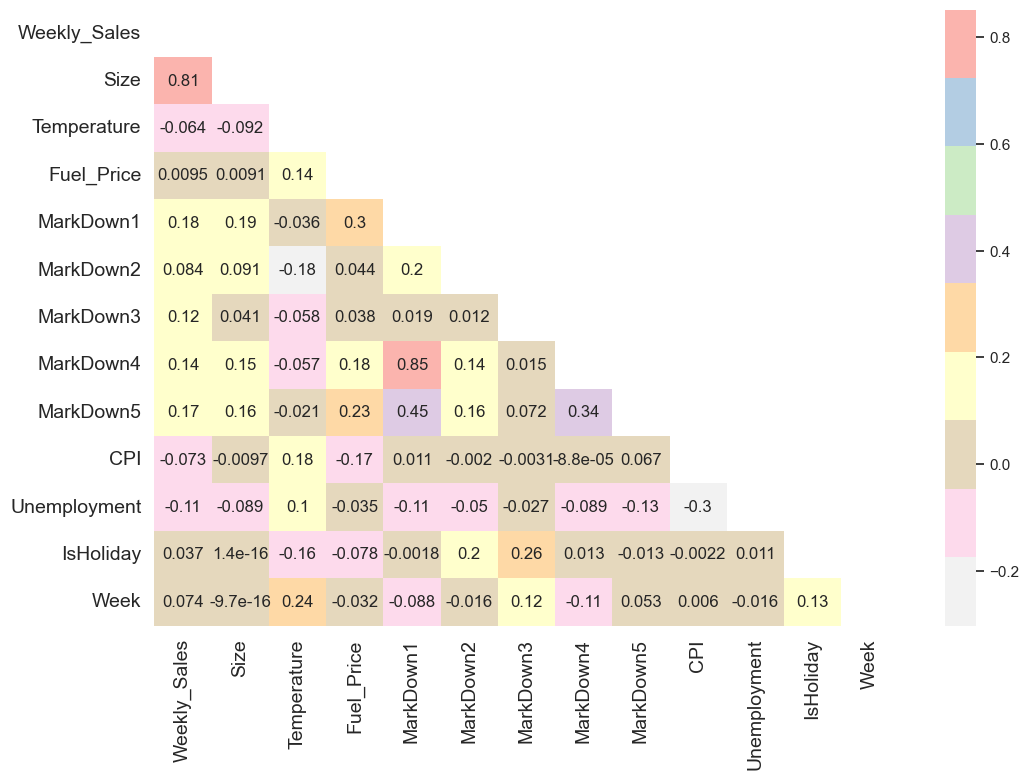

In [51]:
correlation_heat_map(data_heatmap_df)

#inference: By checking the direct correlation of features there is no much promising correlations. 
#           There are no much correlation within the features as well. In a way this is good because 
#           there won't be multicollinearity that we have to take care while running models.


## Plotting data

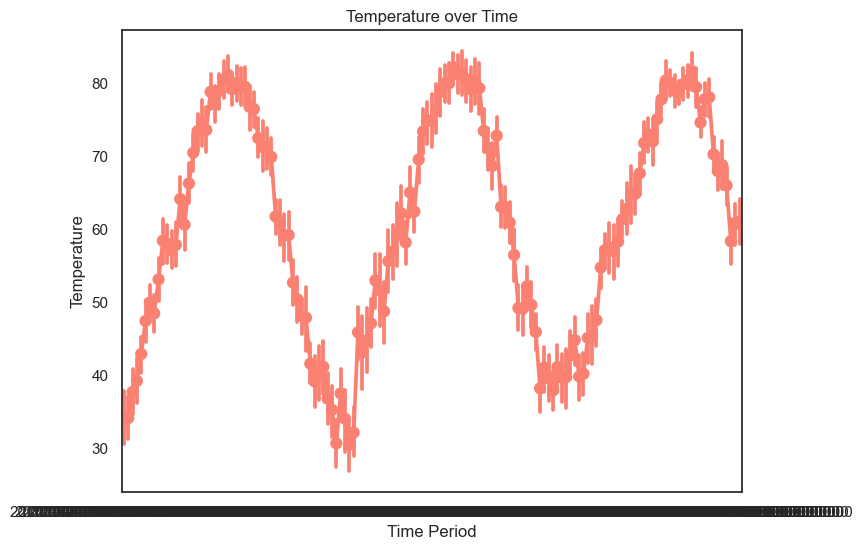

In [52]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
# be an interesting data point that we can use for studies further

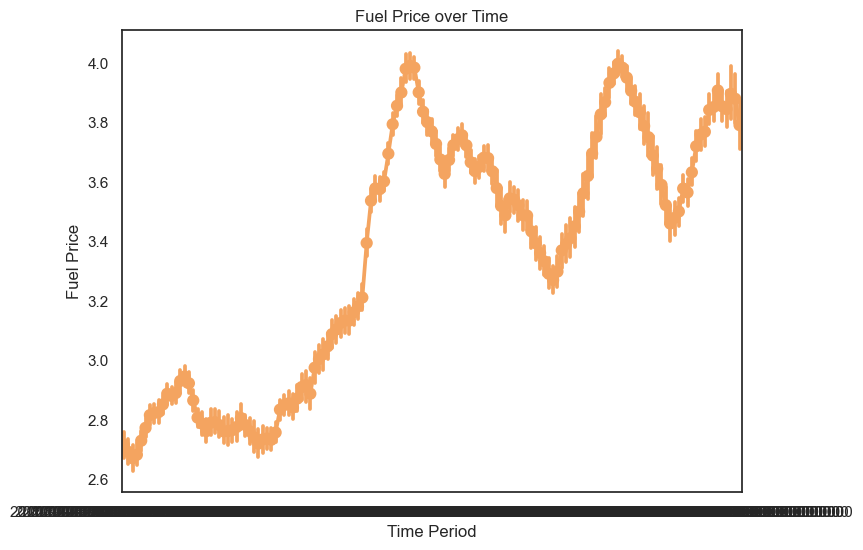

In [53]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows

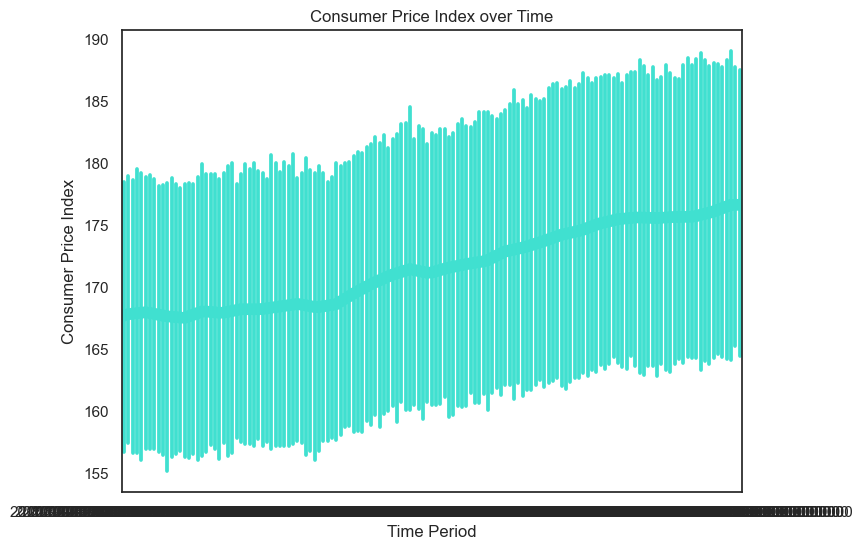

In [54]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much

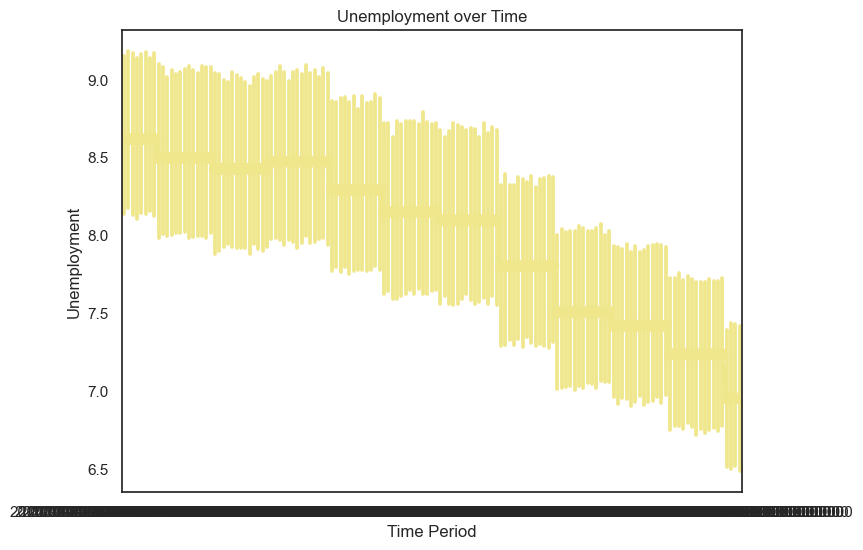

In [55]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales


** This is interesting. Features over time changes quite a bit. We will see whether these have any effects on Sales while we model **

We know that Markdown columns have quiet few outliers it can be because of our imputation as well. So I will take care of that later and try implement a better way of imputation. Eg: KNN imputation, Random value between min and max imputation..

Weekly Sales also seem to have some Outliers but I am keeping it as of now because in our study outliers can be a good thing to check at.


## Visual analysis

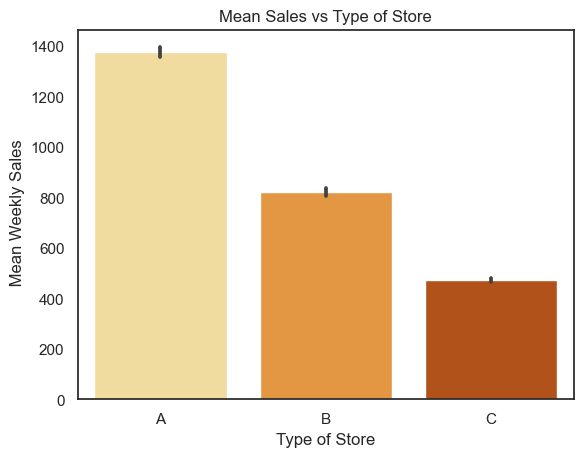

In [56]:
# Checking how the Type of the store have effect on the sales.
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
plt.savefig('./images/Type_vs_Sales.png')
plt.show()

# inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales. 

In [57]:
!pip install tools

# Lets look through the size of the Store and the the type to see is there any relationship

#credits: Joe Kington Stack overflow
groups = data.groupby('Type')
# Plot
plt.rcParams.update(tools.plotting.mpl_stylesheet)
colors = tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots(figsize=(8,8))
ax.set_color_cycle(colors)
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.Store,group.Size, marker='o', linestyle='', ms=12, label=name)
ax.legend(numpoints=1, loc='upper left')
plt.savefig('./images/Type_vs_Size.png')
plt.show()

# inference :  From the figure its clear that Type of the Store have a relation ship with the size of the store
#              Type A > Type B > Type C Which is the usual pattern in Size as well as Sales
#              Types might be a classification according to the min sq ft(size) 

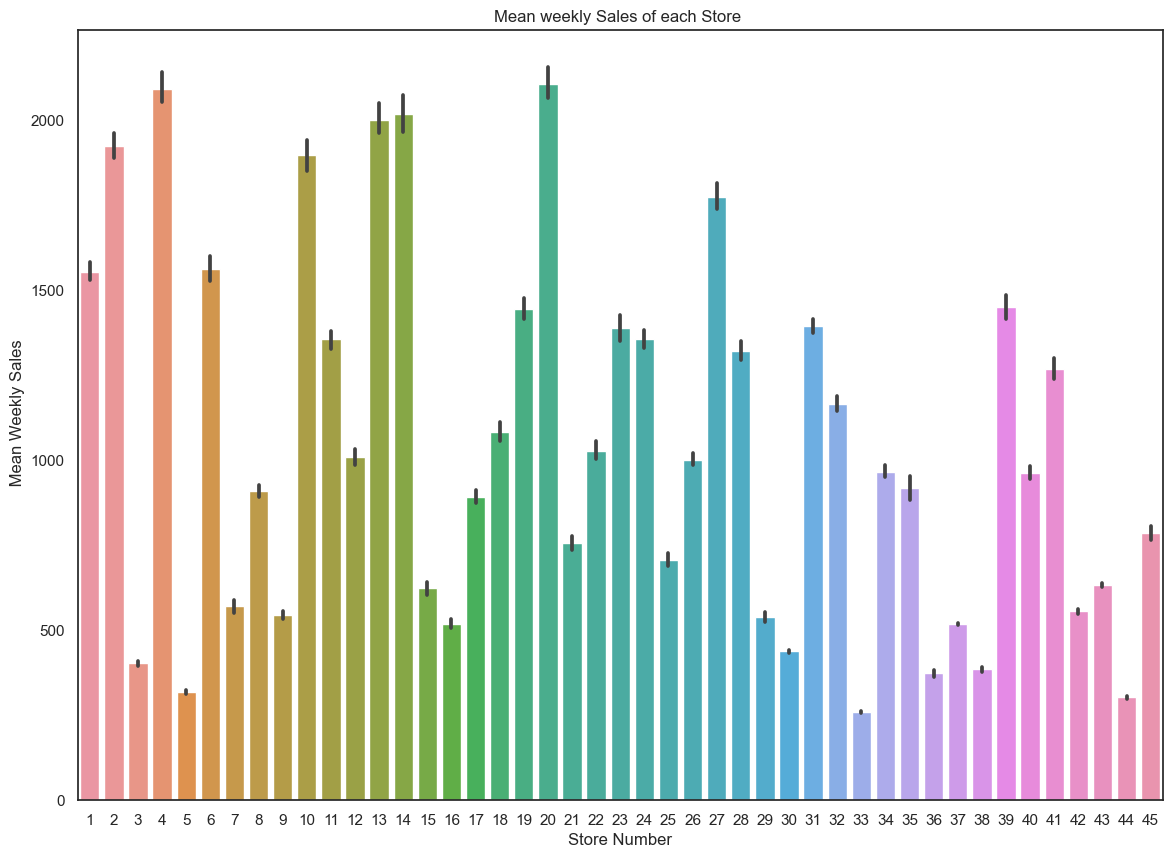

In [58]:
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
#             to $2,200,000

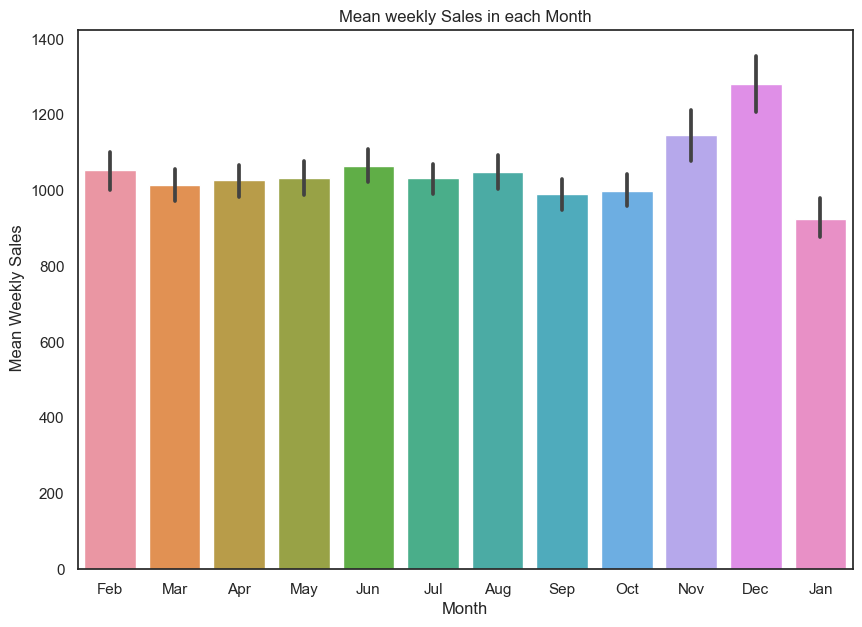

In [59]:
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales 
#            compared to every other month and January have the least sales. 

#### Summary:
I have done the basic cleaning and EDA.Plots and there inference from it will help me to further go up with modeling and understanding my data. Now I will move on to modeling

### Feature Engineering 
Before creating and running model I will look through the columns and make meaningful columns and create dummies where needed. One another field I have to take care is the Markdown1-5 which have a lot of missing values. 

I will create dummies for **"Store, Month, Year" **

I am planning to change the **DAY** and create dummies out of it. But I guess more than taking the which day it will be better to see **which week of the month** it is, since that can have effect on the sales according to the salary weeks or something else.

**MarkDown1-5** I have to figure out a way to impute and try to use. If I am not able to come up with a good prediction for those I might have to drop some rows


In [60]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [61]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [62]:
# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

In [63]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 


Now everything else is perfect except **Markdown1-5** columns. I have to deal with those -500 which I have imputed earlier.
** Actually we should just drop those columns since we have around 65% missing value** 

Here in this case I will try **KNN (K Nearest Neighbours) imputation**. This might not be a big success but according to current situation that might be the best way so that I can use those variables for modeling and try how this comes out. Other ways are imputing with 0, median value, random value but those will put same value in all missing data and that can be very miss leading or bad way to do it.
** Lets assume this is a good imputation and see whether there would be any effect in sales according to the MarkDowns**

### KNN model imputation


In [64]:
data.iloc[:,5:10].describe().T

# Inference: more than 50% is missing values with (-500) so imputing with KNN might not be a good idea. 
# But what are the other methods? imputing with random values in the range of that particular columns?
# Lets try that first.


count         mean          std    min    25%    50%       75%  \
MarkDown1  6435.0  2106.175500  6008.334618 -500.0 -500.0 -500.0  2302.300   
MarkDown2  6435.0   446.067837  4946.234382 -500.0 -500.0 -500.0     0.090   
MarkDown3  6435.0    88.158396  5306.320800 -500.0 -500.0 -500.0     3.705   
MarkDown4  6435.0   661.551088  3853.055534 -500.0 -500.0 -500.0   314.320   
MarkDown5  6435.0  1260.128491  4227.342723 -500.0 -500.0 -500.0  1983.265   

                 max  
MarkDown1   88646.76  
MarkDown2  104519.54  
MarkDown3  141630.61  
MarkDown4   67474.85  
MarkDown5  108519.28

In [65]:
data.MarkDown1=data.MarkDown1.map(lambda x: np.nan if x==-500 else x)
data.MarkDown2=data.MarkDown2.map(lambda x: np.nan if x==-500 else x)
data.MarkDown3=data.MarkDown3.map(lambda x: np.nan if x==-500 else x)
data.MarkDown4=data.MarkDown4.map(lambda x: np.nan if x==-500 else x)
data.MarkDown5=data.MarkDown5.map(lambda x: np.nan if x==-500 else x)

In [66]:
missing_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

# Not including our actual y(Weekly Sales) and Size of store for Markdown since by including weekly sales
# It can be a bad method to use those MarkDown again for predicting weekly sales. 

impute_cols = [c for c in data.columns if not c in ['Weekly_Sales','Date','Sqrt_Sales','lnSales']+missing_cols]

data_imputed=data.copy()


In [67]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print ("Best R2 value:",np.max(r2s),"\nBest k: ",np.argmax(k_range))
    return np.argmax(k_range)

In [68]:
impute_missing = data.loc[data.MarkDown1.isnull(), :]
impute_valid = data.loc[~data.MarkDown1.isnull(), :]

y = impute_valid.MarkDown1.values
X = impute_valid[impute_cols]

Xs = ss.fit_transform(X)

Best R2 value: 0.14140639091506765 
Best k:  25


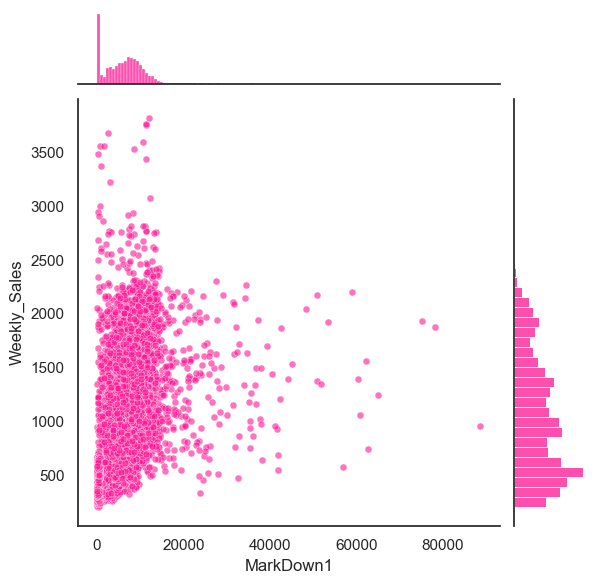

In [69]:
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown1_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown1.isnull(), 'MarkDown1'] = MarkDown1_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown1, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color='deeppink')
plt.show()

Best R2 value: 0.41503402148479146 
Best k:  25


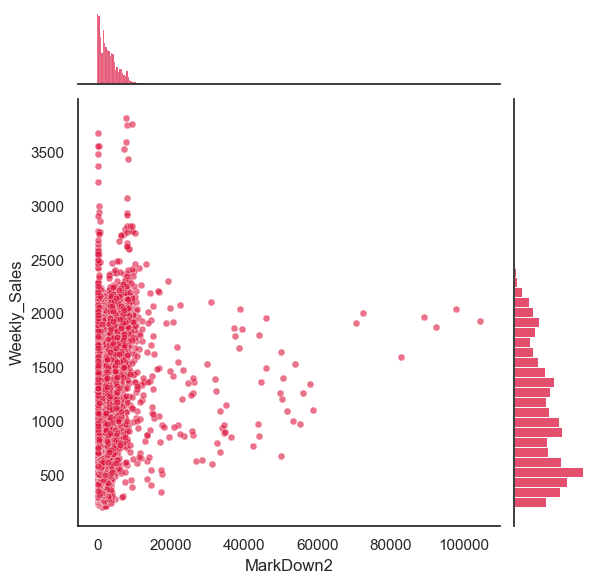

In [70]:
impute_missing = data.loc[data.MarkDown2.isnull(), :]
impute_valid = data.loc[~data.MarkDown2.isnull(), :]

y = impute_valid.MarkDown2.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown2_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown2.isnull(), 'MarkDown2'] = MarkDown2_impute

#Lets look how the MarkDown1 vs Weekly_Sales appear
sns.jointplot(data_imputed.MarkDown2, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'crimson')
plt.show()

Best R2 value: 0.20431863554303203 
Best k:  25


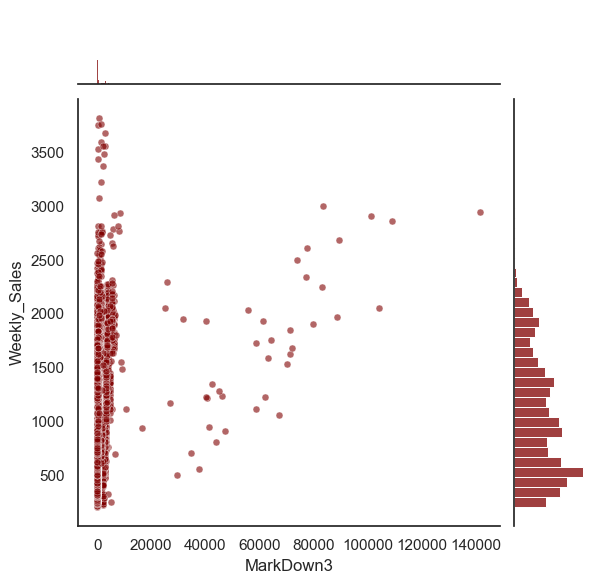

In [71]:
impute_missing = data.loc[data.MarkDown3.isnull(), :]
impute_valid = data.loc[~data.MarkDown3.isnull(), :]

y = impute_valid.MarkDown3.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown3_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown3.isnull(), 'MarkDown3'] = MarkDown3_impute

sns.jointplot(data_imputed.MarkDown3, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color= 'maroon')
plt.show()

Best R2 value: 0.3470822603116795 
Best k:  25


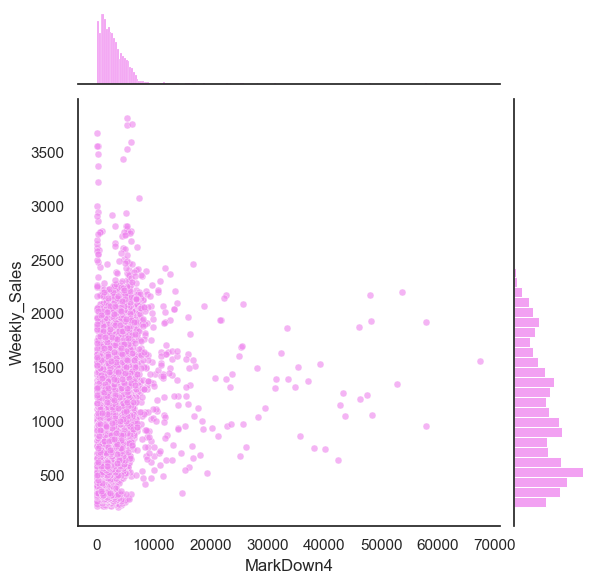

In [72]:
impute_missing = data.loc[data.MarkDown4.isnull(), :]
impute_valid = data.loc[~data.MarkDown4.isnull(), :]

y = impute_valid.MarkDown4.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown4_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown4.isnull(), 'MarkDown4'] = MarkDown4_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'violet')
plt.show()

Best R2 value: 0.0815206539204145 
Best k:  25


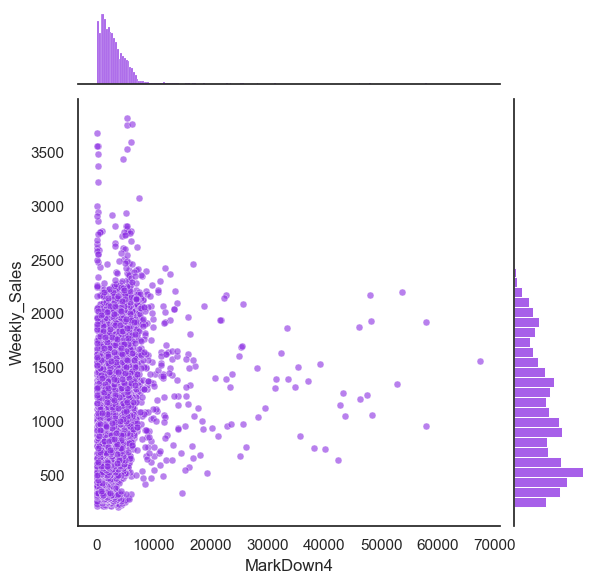

In [73]:
impute_missing = data.loc[data.MarkDown5.isnull(), :]
impute_valid = data.loc[~data.MarkDown5.isnull(), :]

y = impute_valid.MarkDown5.values
X = impute_valid[impute_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)
best_k = find_best_k_reg(Xs, y)
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

MarkDown5_impute = knn.predict(X_miss_s)

data_imputed.loc[data.MarkDown5.isnull(), 'MarkDown5'] = MarkDown5_impute

sns.jointplot(data_imputed.MarkDown4, data_imputed.Weekly_Sales, joint_kws=dict(s=25, alpha=0.6), color = 'blueviolet')
plt.show()

In [74]:
walmart_data=data_imputed.copy()

# The accuracy and R2 are very bad. This means that we likely imputing crap with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

So finally we have replaced all missing values in **MarkDown1-5** with **KNN imputation** from the given value range itself. We will see the performance of the model and see through whether we have any better methods. As of now my assumption is KNN imputation values would work because thats the best way we have.

** Lets Try Linear Regression for predicting Weekly_Sales with and without the imputed values and see whether its better to keep the imputed MarkDown Values **


### Modeling


0.947142256240848
0.9428175055925558
Adjusted R^2 0.9465272447568579
Cross-validated scores: [0.94029953 0.9359385  0.94369334 0.93020722 0.93186992 0.95810757
 0.94276003 0.94114693 0.94269717 0.94068287]
Mean Cross validation 0.9407403057927421


Text(0.5, 1.0, 'Predicted vs Actual Sales')

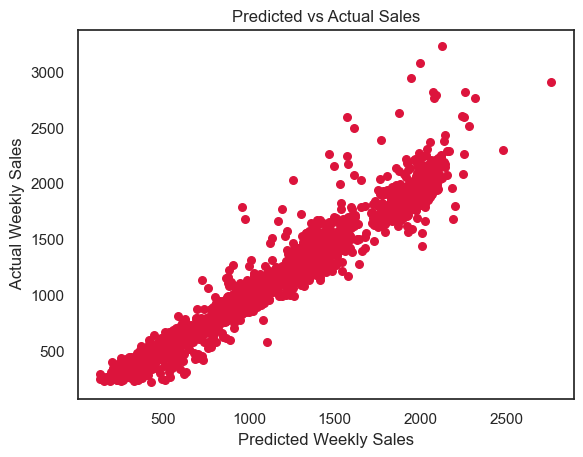

In [75]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

** Now let us look the same model without MarkDowns to check whether data with MarkDown or without MarkDown is good.** 

0.941781923731329
0.9394404384820121
Cross-validated scores: [ 7.00623668e-01 -1.07807653e+13 -2.99363094e+12 -1.86654297e+12
 -8.02688284e+13 -5.67928561e+13 -6.04788152e+13 -1.12379869e+14
 -5.60479094e+12 -3.53094421e+13]
Mean Cross validation -36647554127459.125


Text(0.5, 1.0, 'Predicted vs Actual Sales')

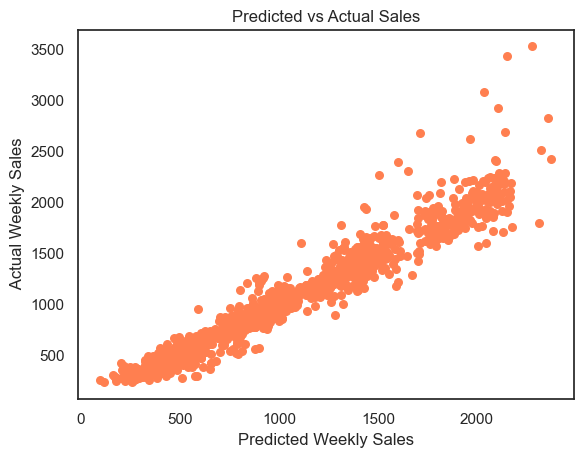

In [76]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

From the Cross validation its clear that the one with Markdown values are better than they are dropped. So I will keep MarkDowns as of now and **assume** the KNN model have imputed the correct values. 
Now lets move on to real **Modeling** for the prediction of Weekly_sales

We have seen that normal running of Linear regression is a very bad idea. Even though it gives a high R2 value the cross validated score doesn't make any sense. Now its time to go on with **feature selection **


In [77]:
data=data_imputed.copy()

** I will divide my train and test datasets first and then deal with that seperately**

In [78]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset

In [79]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

** Before we start lets shuffle the dataframe a bit because while we use crossvalidation for regressors it won't take a random sample as test and train, instead it takes section by section. Here my Dataframe have data for each store in order. So if we take section by section model might not have enough data to learn about certain stores and which intern will give terrible answers**

In [80]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers

In [81]:
data_train.columns

Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type_A', 'Type_B', 'Store_2', 'Store_3',
       'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9',
       'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15',
       'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21',
       'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27',
       'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33',
       'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul',
       'Month_Jun', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct',
       'Month_Sep', 'Year_2011', 'Year_2012', 'Week_1.0', 'Week_2.0',
       'Week_3

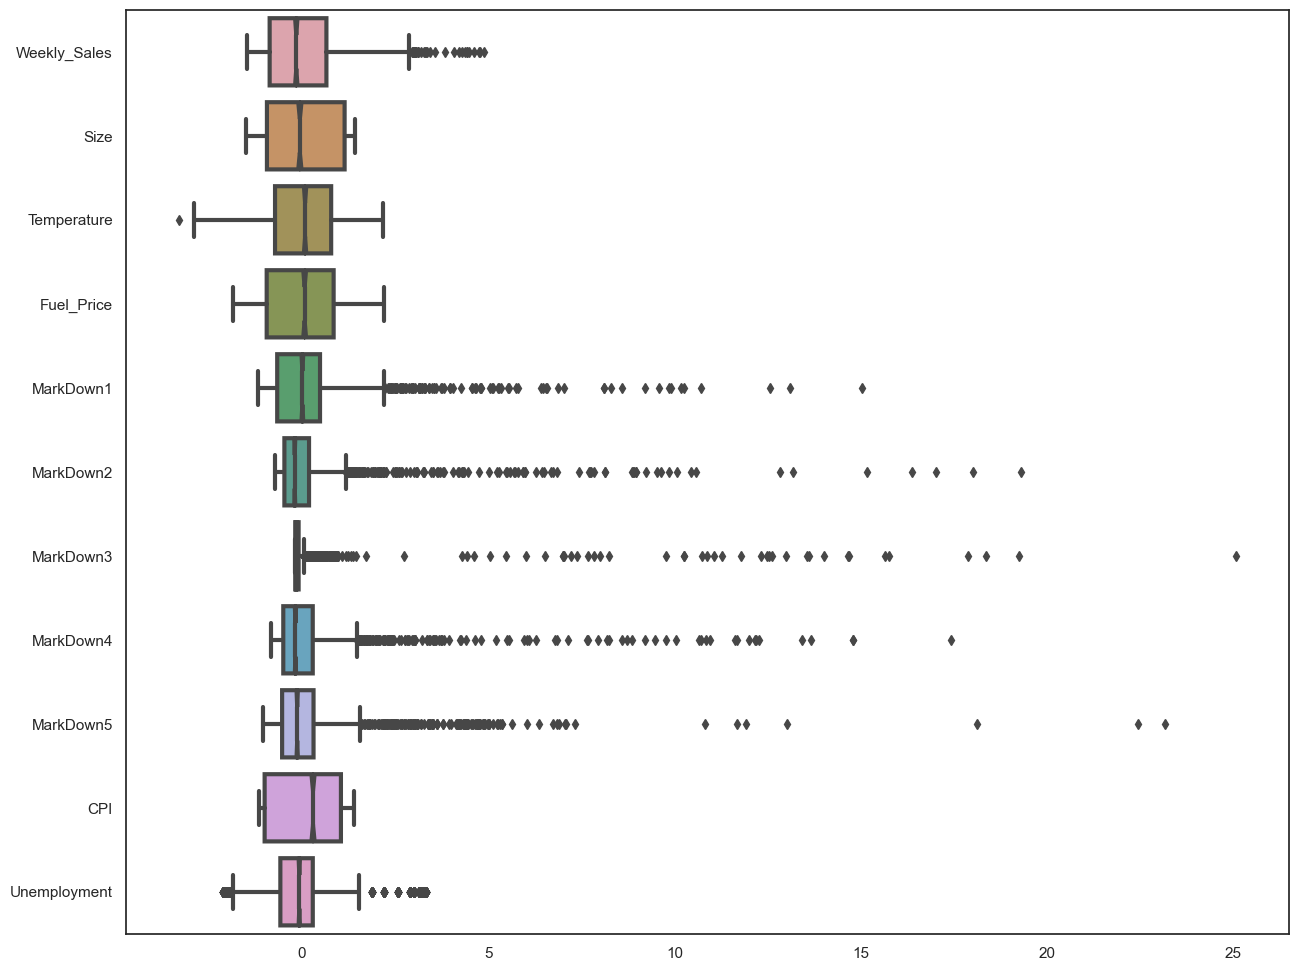

In [82]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

** There are quite a lot of outliers in MarkDown, But Lets first deal the outliers in weekly sales data because we might just drop MarkDowns Later because the percentage of missing values are really high in MarkDowns**

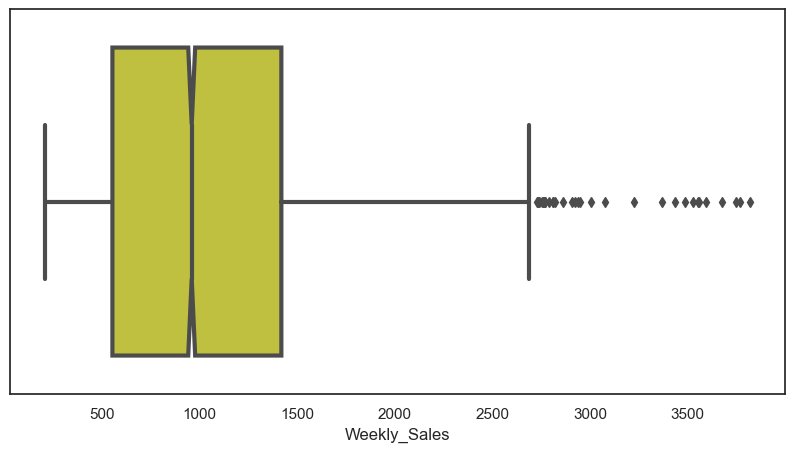

In [83]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [84]:
# Lets consider 3,000,000 as upper limit 
data_train[data_train.Weekly_Sales>3000].shape

(14, 76)

In [85]:
# there is only 14 outliers. Lets drop it and proceed.
data_train=data_train[data_train.Weekly_Sales<3000]

## Tune and evaluate model

### Feature Selection

We have seen the models are giving a terrible crossvalidation score. So lets tune our model. for that first we should figure out what all should we use as our features. For this a feature selection would be the best thing. So lets use Lasso Feature Selection and see how our model works with that.

### Lasso Feature Selection

In [86]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

# I am not using details related to time as my predictors. I will use these in my timeseries model and probably 
# as a seperate model. This is beacuse time itself might explain many of the trends and I would like to
# look more into the effect of other factors.
predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]

#### Test- Train Split such that Test data is last 90 days data (Like a furture 3 months prediction)

In [87]:
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

In [88]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)

In [89]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [90]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

feature        coef     abscoef
0           Size  347.440079  347.440079
11        Type_A  172.384215  172.384215
21      Store_10  131.966692  131.966692
19       Store_8  -98.376268   98.376268
51      Store_40  -92.706010   92.706010
43      Store_32  -89.647948   89.647948
44      Store_33  -85.179793   85.179793
20       Store_9  -77.209609   77.209609
52      Store_41  -77.163473   77.163473
45      Store_34  -75.254886   75.254886
37      Store_26  -74.236073   74.236073
47      Store_36  -74.104517   74.104517
22      Store_11  -69.370005   69.370005
35      Store_24  -59.758579   59.758579
42      Store_31  -58.984018   58.984018
26      Store_15  -53.699262   53.699262
34      Store_23   52.273264   52.273264
36      Store_25  -49.965329   49.965329
32      Store_21  -49.712121   49.712121
30      Store_19  -48.335226   48.335226
9   Unemployment  -46.894832   46.894832
39      Store_28  -46.295713   46.295713
25      Store_14   40.361164   40.361164
31      Store_20   39.469250   39.469250
5      MarkDown3   38.995491   38.995491
50      Store_39  -38.738596   38.738596
55      Store_44  -37.788295   37.788295
17       Store_6  -36.175284   36.175284
16       Store_5  -35.272260   35.272260
40      Store_29  -34.947106   34.947106
23      Store_12   33.918002   33.918002
15       Store_4   32.747364   32.747364
27      Store_16  -24.775158   24.775158
56      Store_45  -23.330999   23.330999
14       Store_3  -21.384872   21.384872
18       Store_7  -20.438032   20.438032
54      Store_43   20.253820   20.253820
29      Store_18   19.693823   19.693823
41      Store_30  -18.265050   18.265050
13       Store_2   16.940394   16.940394
4      MarkDown2  -13.557513   13.557513
24      Store_13   11.418004   11.418004
1    Temperature  -11.400903   11.400903
2     Fuel_Price  -10.287153   10.287153
10     IsHoliday    9.922931    9.922931
33      Store_22    9.539345    9.539345
8            CPI    8.564592    8.564592
46      Store_35    8.259022    8.259022
53      Store_42    7.978034    7.978034
7      MarkDown5    4.842193    4.842193
48      Store_37   -2.774176    2.774176
28      Store_17    1.988387    1.988387
6      MarkDown4   -1.807744    1.807744

** The list of features that are seleted and their magnitude of effect on weekly sales can be seen above (remember the target is scaled down)**

** We will set the predictors that we got from Lasso as our actual predictors and use in further models**

In [91]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [92]:
# Lets see the best alpha score
lasso_cv.alpha_

#best alpha value is 0.45384197291954748 which could be used later to run model

0.4538419729195478

In [93]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=0.4538419729195478)

In [94]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.92816133 0.91967013 0.94586075 0.9454227  0.94169941 0.92943858
 0.92448649 0.93988748 0.93070806 0.92867555]
0.93340104821547


** Thats great. getting a cross validated score of .933 is good. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting**

In [95]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9602241138737961
Adjusted R2:  0.9559219781827266


In [96]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 500899948.5893169
Test Residual 39751906.32790466
Residual ratio of Test to Train 0.07936097106789057


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size. 


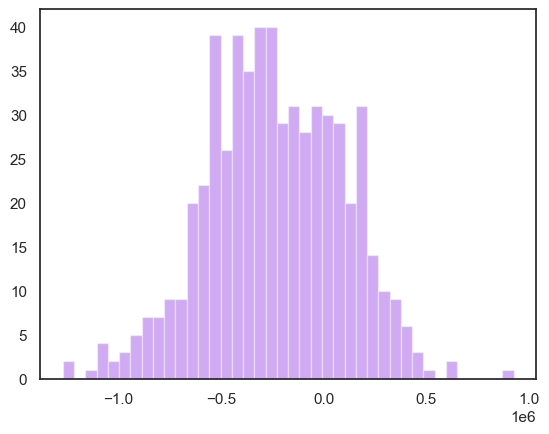

In [121]:
sns.distplot(test_resids, kde=False, bins=40, color = 'blueviolet')
plt.show()

# The residuals looks ok and almost like a normal distribution

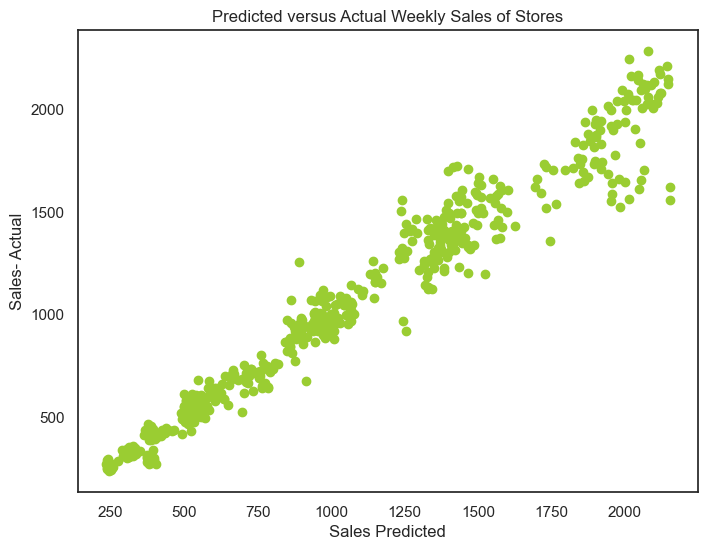

In [98]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving me a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. ** The actual vs Predicted Sales looks promising** 

### Setting the predictors from Lasso and Train Test split for further use

I will set my predictors to the ones that are selected from Lasso and will use this predictors and Train Test split for further use in all my models.

In [99]:
X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


## Model selection and implementation process

I have already implemented Lasso Regressor and would be looking through and implementing different model of regressors in this part. This is more or a trail and error method with the know models that could do better in Regressions

#### Decision Tree

I have tried a decision tree and it was not working good. The one with max_depth=N gives a good crossvalidation score on train data but when I put that in test data it gives me terrible score. This could be because of over learning or **over fitting**
Now I will go into Random Forest Regressor which is a ensemble method of decision tree and check how it works.

### Random Forest Regressor

In [100]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')

In [101]:
# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.9496765105610585

In [102]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.7975573003232623
Adjusted R2:  0.7773511551577876


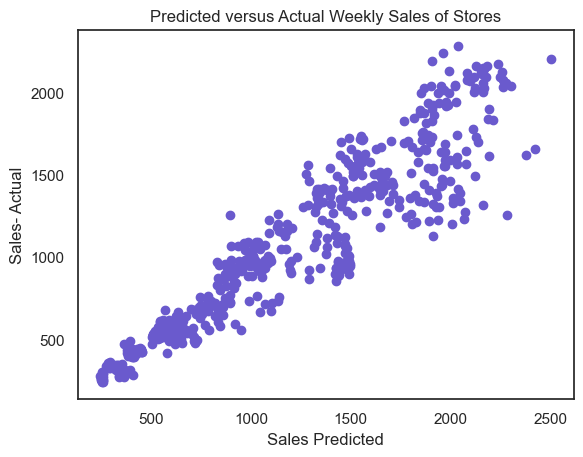

In [103]:
plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [104]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149867313.1237999
Test Residual 89815932.0046
Residual ratio of Test to Train 0.599303010993507


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.

### GradientBoostingRegressor

In [105]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [106]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9510133568361486

In [107]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.7661811312363218
Adjusted R2:  0.7428432780452202


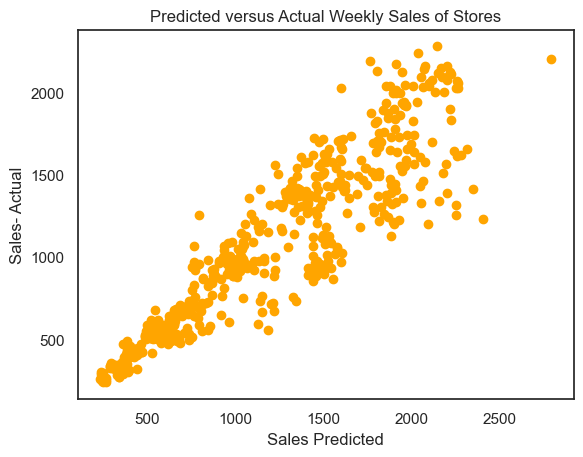

In [108]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [109]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 70612589.50101236
Test Residual 95296045.38849935
Residual ratio of Test to Train 1.3495616866894977


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign.
I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.** This is a clear case of over fitting and we wont use this model further. **

### Support Vector Regression

In [110]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [111]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.506934104365343

In [112]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  0.4046521054266671
Adjusted R2:  0.34522943421689944


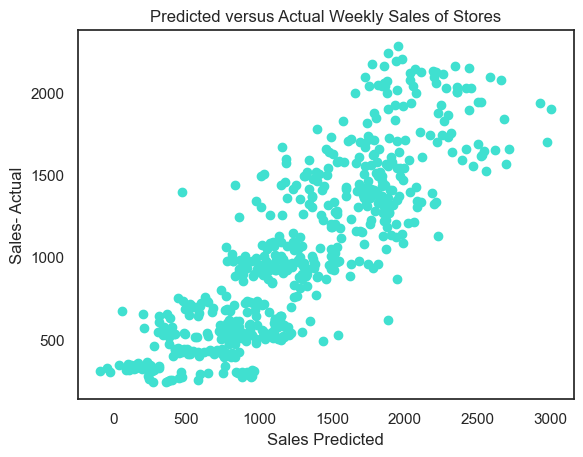

In [113]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [114]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 149867313.1237999
Test Residual 192235311.08143175
Residual ratio of Test to Train 1.2827033932518241


**This looks great!** The cross validation score and score on test data are almost same even though its not a very high percentage. Even the residuals are small. This tells atleast there is no much overfittig.

**So out of all models the best comes with Lasso regression** 

In [115]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [116]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

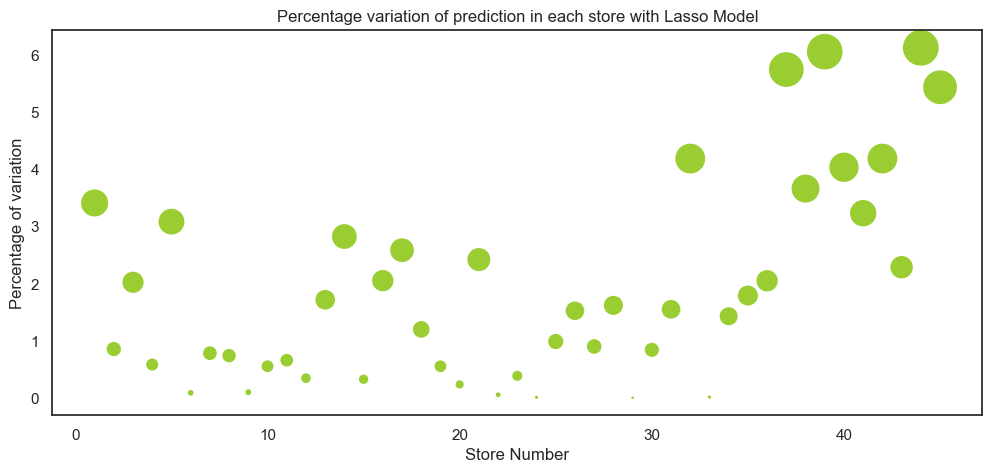

In [117]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

This plot shows the variation of prediction or the percentage residual change for each store. Here **the smaller the bubble the better it is** since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.


In [118]:
# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting','SupportVector')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score,svr_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2,svr_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue,svr_residue)

## Conclusion
### Interpret findings and relate to goals/criteria

So from the modeling Have found Lasso method works the best by itself with an accuracy of .93. The rain forest regressor and SVR also works good. I have plotted a percentage residual change with bubbles to check how good is the prediction for each store.  This could be a good method to look into each store and see which stores are doing good with this model and which are not. So similarly I could find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

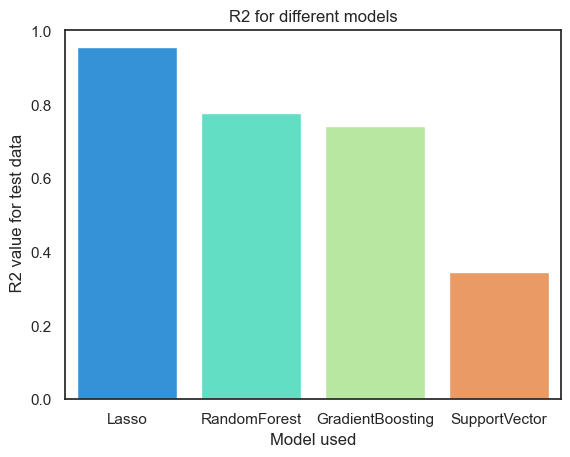

In [119]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
plt.savefig('./images/R2_for_different_models.png')
plt.show()


Here I have found the model that works best for solving my problem statement of predicting the sales of each stores. Lasso Regressor gives the best prediction if we look into the R2 values.

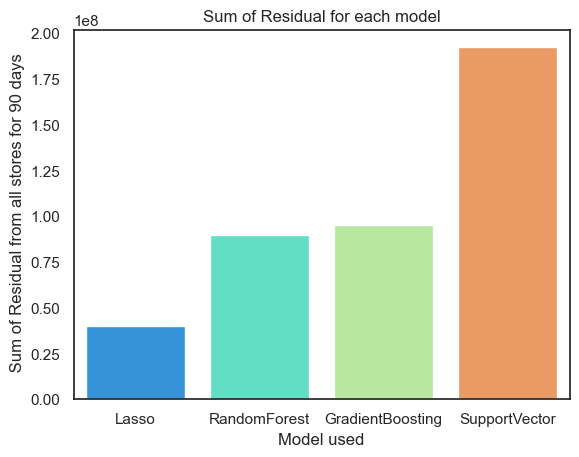

In [120]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual from all stores for 90 days')
plt.title('Sum of Residual for each model')
plt.savefig('./images/Residual_for_different_models.png')
plt.show()

Even The residual for Lasso model is way smaller compared to other models

### Recommendation and Benefits

1. Size of the store is the highest contributing predictor in the model.
2. Store them selves have a prediction power.
3. The Sales are very high in November and December and goes down in january. So its better to employee more staff as casual employee in november and december and encourage permanent staff to take leave on January.
4. The predicted sales data can be used to analyse the sales pattern and adjust the staff in the store. 
5. When I implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which would help to cost cutting in inventory management, supply chain managemen and human resource.

## Next steps

The Next steps would be 

1. To check into the store that have poor prediction and check deep what makes those bad. 
2. To further improve the predictive model using the ensembling method to combine models and come with better model.
3. Take the data to Department level and to predict the Department level sales which would help to solve the inventory management issues and supply chain management.